[Table of Contents](./table_of_contents.ipynb)

# Multivariate Kalman Filters

Filtering Multiple Random Variables

In [82]:
%matplotlib inline

In [83]:
#format the book
import book_format
book_format.set_style()

## Introduction

We are now ready to study and implement the full, multivariate form of the Kalman filter. In the last chapter we learned how multivariate Gaussians express the correlation between multiple random variables, such as the position and velocity of an aircraft. We also learned how correlation between variables drastically improves the posterior. If we only roughly know position and velocity, but they are correlated, then our new estimate can be very accurate.

I prefer that you develop an intuition for how these filters work through several worked examples. I'm going to gloss over many issues. Some things I show you will only work for special cases, others will be 'magical' - it will not be clear how I derived a certain result. If I started with rigorous, generalized equations you would be left scratching your head about what all these terms mean and how you might apply them to your problem. In later chapters I will provide a more rigorous mathematical foundation, and at that time I will have to either correct approximations that I made in this chapter or provide additional information that I did not cover here. 

To make this possible we will restrict ourselves to a subset of problems which we can describe with Newton's equations of motion. These filters are called *discretized continuous-time kinematic filters*. In the **Kalman Filter Math** chapter we will develop the math for non-Newtonian systems. 

## Newton's Equations of Motion

Newton's equations of motion tells us that given a constant velocity $v$ of a system we can compute its position $x$ after time $t$ with:

$$x = vt + x_0$$

For example, if we start at position 13, our velocity is 10 m/s, and we travel for 12 seconds our final position is 133 ($10\times 12 + 13$).

We can incorporate constant acceleration with this equation

$$x = \frac{1}{2}at^2 + v_0t + x_0$$

And if we assume constant jerk we get

$$x = \frac{1}{6}jt^3 +  \frac{1}{2}a_0 t^2 + v_0 t + x_0$$

These equations were generated by integrating a differential equation. Given a constant velocity v we can compute the distance traveled over time with the equation

$$x = vt + x_0$$

which we can derive with

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$


When you design a Kalman filter you start with a system of differential equations that describe the dynamics of the system. Most systems of differential equations do not easily integrate in this way. We start with Newton's equation because we can integrate and get a closed form solution, which makes the Kalman filter easier to design. An added benefit is that Newton's equations are the right equations to use to track moving objects, one of the main uses of Kalman filters.

## Kalman Filter Algorithm

The algorithm is the same Bayesian filter algorithm that we have used in every chapter. The update step is slightly more complicated, but I will explain why when we get to it.

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state
    
**Predict**

    1. Use process model to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Compute scaling factor based on whether the measurement
    or prediction is more accurate
    4. set state between the prediction and measurement based 
    on scaling factor
    5. update belief in the state based on how certain we are 
    in the measurement
    
As a reminder, here is a graphical depiction of the algorithm:

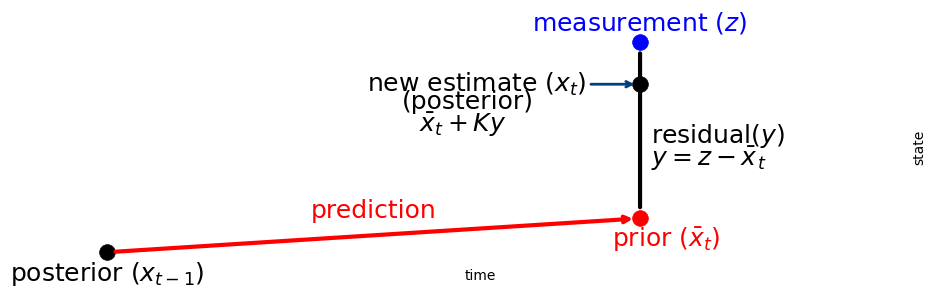

In [84]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

The univariate Kalman filter represented the state with a univariate Gaussian. Naturally the multivariate Kalman filter will use a multivariate Gaussian for the state. We learned in the last chapter that multivariate Gaussians use a vector for the mean and a matrix for the covariances. That means that the Kalman filter needs to use linear algebra to perform the estimations.

I don't want you to memorize these equations, but I have listed the univariate and multivariate equations below. They are quite similar.

<u>**Predict**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

Without worrying about the specifics of the linear algebra, we can see that:

$\mathbf x,\, \mathbf P$ are the state mean and covariance. They correspond to $x$ and $\sigma^2$.

$\mathbf F$ is the *state transition function*. When multiplied by $\bf x$ it computes the prior. 

$\mathbf Q$ is the process covariance. It corresponds to $\sigma^2_{f_x}$.

$\mathbf B$ and $\mathbf u$ are new to us. They let us model control inputs to the system.

<u>**Update**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ is the measurement function. We haven't seen this yet in this book and I'll explain it later. If you mentally remove $\mathbf H$ from the equations, you should be able to see these equations are similar as well.

$\mathbf z,\, \mathbf R$ are the measurement mean and noise covariance. They correspond to $z$ and $\sigma_z^2$ in the univariate filter (I've substituted $\mu$ with $x$ for the univariate equations to make the notation as similar as possible).

$\mathbf y$ and $\mathbf K$ are the residual and Kalman gain. 

The details will be different than the univariate filter because these are vectors and matrices, but the concepts are exactly the same: 

-  Use a Gaussian to represent our estimate of the state and error
-  Use a Gaussian to represent the measurement and its error
-  Use a Gaussian to represent the process model
-  Use the process model to predict the next state (the prior)
-  Form an estimate part way between the measurement and the prior

Your job as a designer will be to design the state $\left(\mathbf x, \mathbf P\right)$, the process $\left(\mathbf F, \mathbf Q\right)$, the measurement $\left(\mathbf z, \mathbf R\right)$, and the  measurement function $\mathbf H$. If the system has control inputs, such as a robot, you will also design $\mathbf B$ and $\mathbf u$.

I have programmed the equations of the Kalman filter into the `predict` and `update` functions in FilterPy. You will import them with:

```python
from filterpy.kalman import predict, update
```

## Tracking a Dog

Let's go back to our tried and true problem of tracking a dog. This time we will include the fundamental insight of the previous chapter and use *hidden variables* to improve our estimates. I could start with the math, but instead let's implement a filter, learning as we go. On the surface the math is different and perhaps more complicated than the previous chapters, but the ideas are all the same - we are just multiplying and adding Gaussians.

We start by writing a simulation for the dog. The simulation will run for `count` steps, moving the dog forward approximately 1 meter for each step. At each step the velocity will vary according to the process variance `process_var`. After updating the position we compute a measurement with an assumed sensor variance of `z_var`. The function returns an NumPy array of the positions and another of the measurements.

In [85]:
import math
import numpy as np
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

## Predict Step

For the prediction we need to design the state and covariance, the process model and the process noise, and optionally the control input. We'll take them in order.

### Design State Variable

We previously tracked a dog in one dimension by using a Gaussian. The mean $(\mu)$ represented the most likely position, and the variance ($\sigma^2$) represented the probability distribution of the position. The position is the *state* of the system, and we call $\mu$ the *state variable*. 

In this problem we will be tracking both the position and velocity of the dog. This requires us to use a multivariate Gaussian represented with the state vector $\mathbf x$ and its corresponding covariance matrix $\mathbf P$. 

State variables can either be *observed variables* - directly measured by a sensor, or *hidden variables* - inferred from the observed variables. For our dog tracking problem the sensor only reads position, so position is observed and velocity is hidden. We will learn how to track hidden variables soon.

It is important to understand that tracking position and velocity is a design choice with implications and assumptions that we are not yet prepared to explore. For example, we could also track acceleration, or even jerk. For now, recall that in the last chapter we showed that including velocity in the covariance matrix resulted in much smaller variances in position. We will learn how the Kalman filter computes estimates for hidden variables later in this chapter. 

In the univariate chapter we represented the dog's position with a scalar value (e.g. $\mu=3.27$). In the last chapter we learned to use a multivariate Gaussian for multiple variables. For example, if we wanted to specify a position of 10.0 m and a velocity of 4.5 m/s, we would write:

$$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$

The Kalman filter is implemented using linear algebra. We use an $n\times 1$ matrix (called a *vector*) to store  $n$ state variables. For the dog tracking problem, we use $x$ to denote position, and the first derivative of $x$, $\dot x$, for velocity. I use Newton's dot notation for derivatives; $\dot x$ represents the first derivative of x with respect to t: $\dot x = \frac{dx}{dt}$. Kalman filter equations use $\mathbf x$ for the state, so we define $\mathbf x$ as:

$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$

We use $\mathbf x$ instead of $\mu$, but recognize this is the mean of the multivariate Gaussian.

Another way to write this is $\mathbf x =\begin{bmatrix}x & \dot x\end{bmatrix}^\mathsf T$ because the transpose of a row vector is a column vector. This notation is easier to use in text because it takes less vertical space.

$\mathbf x$ and the position $x$ coincidentally have the same name. If we were tracking the dog in the y-axis we would write $\mathbf x =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$, not  $\mathbf y =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$. $\mathbf x$ is the standard name for the state variable used in the Kalman filter literature and we will not vary it to give it a more meaningful name. This consistency in naming allows us to communicate with our peers.

Let's code this. Initialization of `x` is as simple as

In [86]:
x = np.array([[10.0],
              [4.5]])
x

array([[10. ],
       [ 4.5]])

I often use the transpose in my code to turn a row matrix into a column vector, as I find it easier to type and read:

In [87]:
x = np.array([[10., 4.5]]).T
x

array([[10. ],
       [ 4.5]])

However, NumPy recognizes 1D arrays as vectors, so I can simplify this line to use a 1D array.

In [88]:
x = np.array([10.0, 4.5])
x

array([10. ,  4.5])

All of the array elements have the same type, typically either `float` or `int`. If the list contains all `int`s then the created array will also have a data type of `int`, otherwise it will be `float`. I will often take advantage of this by only specifying one number as a floating point:

In [89]:
np.array([1., 0, 0, 0, 0, 0])

array([1., 0., 0., 0., 0., 0.])

Here are some examples.

In [90]:
A = np.array([[1, 2], [3, 4]])
x = np.array([[10.0], [4.5]])

# matrix multiply
print(np.dot(A, x))
print()

[[19.]
 [48.]]



In Python 3.5+ we have the matrix multiplier @, where `np.dot(A, B) == A @ B`. It is somewhat less useful then you might realize because it requires both `A` and `B` to be arrays. It is entirely valid in the math in this book for some of these variables to be scalars, therefore the utility of `@` is often lost. 

In [91]:
# alternative matrix multiply)
print(A @ x)
print()

x = np.array([[10.0, 4.5]]).T
print(A @ x)
print()

x = np.array([10.0, 4.5])
print(A @ x)

[[19.]
 [48.]]

[[19.]
 [48.]]

[19. 48.]


The last returns a 1D array, but I have written the Kalman filter class to be able to handle this. In retrospect that might lead to confusion, but it does work. 

### Design State Covariance

The other half of the state Gaussian is the covariance matrix $\mathbf P$. In the univariate Kalman filter we specified an initial value for $\sigma^2$, and then the filter took care of updating its value as measurements were added to the filter. The same thing happens in the multidimensional Kalman filter. We specify an initial value for $\mathbf P$ and the filter updates it during each epoch.

We need to set the variances to reasonable values. For example, we may choose $\sigma_\mathtt{pos}^2=500 m^2$ if we are quite uncertain about the initial position. Top speed for a dog is around 21 m/s, so in the absence of any other information about the velocity we can set $3\sigma_\mathtt{vel}=21$, or $\sigma_\mathtt{vel}^2=7^2=49$. 

In the last chapter we showed that the position and velocities are correlated. But how correlated are they for a dog? I have no idea. As we will see the filter computes this for us, so I initialize the covariances to zero. Of course, if you know the covariances you should use them.

Recall that the diagonals of the covariance matrix contains the variance of each variable, and the off-diagonal elements contains the covariances. Thus we have:

$$
\mathbf P = \begin{bmatrix}500 & 0 \\ 0&49\end{bmatrix}
$$

We can use `numpy.diag`, which creates a diagonal matrix from the values for the diagonal. Recall from linear algebra that a diagonal matrix is one with zeros in the off-diagonal elements.

In [92]:
P = np.diag([500., 49.])
P

array([[500.,   0.],
       [  0.,  49.]])

I could have written:

In [93]:
P = np.array([[500., 0.],
              [0., 49.]])
P

array([[500.,   0.],
       [  0.,  49.]])

We are done. We've expressed the state of the filter as a multivariate Gaussian and implemented it in code.

###  Design the Process Model

The next step is designing the *process model*. It is a mathematical model which describes the behavior of the system. The filter uses it to predict the state after a discrete time step. We do this with a set of equations that describe the dynamics of the system.

In the univariate chapter we modeled the dog's motion with

$$ x = v \Delta t + x_0$$

We implemented this as follows:

```python
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, 
                    pos.var + movement.var)
```

We will do the same thing in this chapter, using multivariate Gaussians instead of univariate Gaussians. You might imagine this sort of implementation:

$$ \mathbf x = \begin{bmatrix}5.4\\4.2\end{bmatrix}, \, \, 
\dot{\mathbf x} =  \begin{bmatrix}1.1\\0.\end{bmatrix} \\
\mathbf x = \dot{\mathbf x}t + \mathbf x$$

But we need to generalize this. The Kalman filter equations work with any linear system, not just Newtonian ones. Maybe the system you are filtering is the plumbing system in a chemical plant, and the flow in a given pipe is determined by a linear combination of the settings of different valves. 

$$\mathtt{pipe_1} = 0.134(\mathtt{valve}_1) + 0.41(\mathtt{valve}_2 - \mathtt{valve}_3) + 1.34$$
$$\mathtt{pipe_2} = 0.210(\mathtt{valve}_2) - 0.62(\mathtt{valve}_1 - \mathtt{valve}_5) + 1.86$$

Linear algebra has a powerful way to express systems of equations. Take this system

$$\begin{cases}
2x+3y=8\\4x-y=2
\end{cases}$$

We can put this in matrix form by writing:

$$\begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix} \begin{bmatrix}x\\y\end{bmatrix} = \begin{bmatrix}8\\2\end{bmatrix}$$

If you perform the [matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication#General_definition_of_the_matrix_product) in this equation the result will be the two equations above. In linear algebra we would write this as $\mathbf{Ax}=\mathbf B$, where

$$\mathbf{A} = \begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix},\, \mathbf x = \begin{bmatrix}x\\y\end{bmatrix}, \mathbf B=\begin{bmatrix}8\\2\end{bmatrix}$$

And then we can use the SciPy's `linalg` package to solve for $\mathbf x$:

In [94]:
from scipy.linalg import solve
A = np.array([[2, 3],[4, -1]])
b = np.array([[8], [2]])
x = solve(A, b)
x

array([[1.],
       [2.]])

We use the process model to perform the *innovation*, because the equations tell us what the next state will be given the current state. Kalman filters implement this using this linear equation, where $\mathbf{\bar x}$ is the *prior*, or predicted state:

$$\mathbf{\bar x} = \mathbf{Fx}$$

which we can make explicit as

$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

Our job as Kalman filters designers is to specify $\mathbf F$ such that $\bar{\mathbf x}  = \mathbf{Fx}$ performs the innovation (prediction) for our system. To do this we need one equation for each state variable. In our problem $\mathbf x = \begin{bmatrix}x & \dot x\end{bmatrix}^\mathtt{T}$, so we need one equation to compute the position $x$ and another to compute the velocity $\dot x$ . We already know the equation for the position innovation:

$$\bar x = x + \dot x \Delta t$$

What is our equation for velocity? We have no predictive model for how our dog's velocity will change over time. In this case we assume that it remains constant between innovations. Of course this is not exactly true, but so long as the velocity doesn't change too much over each innovation you will see that the filter performs very well. So we say

$$\bar{\dot x} = \dot x$$

This gives us the process model for our system 

$$\begin{cases}
\begin{aligned}
\bar x &= x + \dot x \Delta t \\
\bar{\dot x} &= \dot x
\end{aligned}
\end{cases}$$

This correctly has one equation for each variable in the state, isolated on the left hand side. We need to express this set of equations in the form $\bar{\mathbf x}  = \mathbf{Fx}$. Rearranging terms makes it easier to see what to do.

$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$

We can rewrite this in matrix form as

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x \\ \dot x\end{bmatrix}\\
\mathbf{\bar x} &= \mathbf{Fx}
\end{aligned}$$

$\mathbf F$ is called the *state transition function* or the *state transition matrix*. In later chapters it will be a true function, not a  matrix, so calling it a function is a bit more general.

In [95]:
dt = 0.1
F = np.array([[1, dt],
              [0, 1]])
F

array([[1. , 0.1],
       [0. , 1. ]])

Let's test this! FilterPy has a `predict` method that performs the prediction by computing $\mathbf{\bar x} = \mathbf{Fx}$. Let's call it and see what happens. We've set the position to 10.0 and the velocity to  4.5 meter/sec. We've defined `dt = 0.1`, which means the time step is 0.1 seconds, so we expect the new position to be 10.45 meters after the innovation. The velocity should be unchanged.

In [96]:
from filterpy.kalman import predict

x = np.array([10.0, 4.5])
P = np.diag([500, 49])
F = np.array([[1, dt], [0, 1]])

# Q is the process noise
x, P = predict(x=x, P=P, F=F, Q=0)
print('x =', x)

x = [10.45  4.5 ]


This worked. If we call `predict()` several times in a row the value will be updated each time. 

In [97]:
for _ in range(4):
    x, P = predict(x=x, P=P, F=F, Q=0)
    print('x =', x)

x = [10.9  4.5]
x = [11.35  4.5 ]
x = [11.8  4.5]
x = [12.25  4.5 ]


`predict()` computes both the mean and covariance of the innovation. This is the value of $\mathbf P$ after five innovations (predictions), which we denote $\mathbf{\bar P}$ in the Kalman filter equations.

In [98]:
print(P)

[[512.25  24.5 ]
 [ 24.5   49.  ]]


Inspecting the diagonals shows us that the position variance got larger. We've performed five prediction steps with no measurements, and our uncertainty grew. The off-diagonal elements became non-zero - the Kalman filter detected a correlation between position and velocity! The variance of the velocity did not change.

Here I plot the covariance before and after the prediction. The initial value is in solid red, and the prior (prediction) is in dashed black. I've altered the covariance and time step to better illustrate the change.

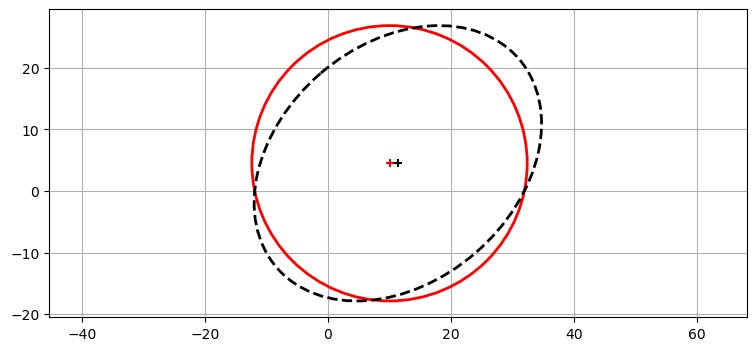

In [99]:
from filterpy.stats import plot_covariance_ellipse

dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

You can see that the center of the ellipse shifted by a small amount (from 10 to 11.35) because the position changed. The ellipse also elongated, showing the correlation between position and velocity. How does the filter compute new values for $\mathbf{\bar P}$, and what is it based on? Note that I set the process noise `Q` to zero each time, so it is not due to me adding noise. It's a little to early to discuss this, but recall that in every filter so far the predict step entailed a loss of information. The same is true here. I will give you the details once we have covered a bit more ground.

### Design Process Noise

A quick review on *process noise*. A car is driving along the road with the cruise control on; it should travel at a constant speed. We model this with $\bar x_k=\dot x_k\Delta t + x_{k-1}$. However, it is affected by a number of unknown factors. The cruise control cannot perfectly maintain a constant velocity. Winds affect the car, as do hills and potholes. Passengers roll down windows, changing the drag profile of the car. 

We can model this system with the differential equation

$$\dot{\mathbf x} = f(\mathbf x) + w$$

where $f(\mathbf x)$ models the state transition and $w$ is *white process noise*.

We will learn how to go from a set of differential equations to the Kalman filter matrices in the **Kalman Filter Math** chapter. In this chapter we take advantage of the fact that Newton already derived the equations of motion for us. For now you just need to know that we account for the  noise in the system by adding a process noise covariance matrix $\mathbf Q$ to the covariance $\mathbf P$. We do not add anything to $\mathbf x$ because the noise is *white* - which means that the mean of the noise will be 0. If the mean is 0, $\mathbf x$ will not change.

The univariate Kalman filter used `variance = variance + process_noise` to compute the variance for the variance of the prediction step. The multivariate Kalman filter does the same, essentially `P = P + Q`. I say 'essentially' because there are other terms unrelated to noise in the covariance equation that we will see later.

Deriving the process noise matrix can be quite demanding, and we will put it off until the Kalman math chapter. For now know that $\mathbf Q$ equals the expected value of the white noise $w$, computed as $\mathbf Q = \mathbb E[\mathbf{ww}^\mathsf T]$. In this chapter we will focus on building an intuitive understanding on how modifying this matrix alters the behavior of the filter.

FilterPy provides functions which compute $\mathbf Q$ for the kinematic problems of this chapter. `Q_discrete_white_noise` takes 3 parameters. `dim`, which specifies the dimension of the matrix, `dt`, which is the time step in seconds, and `var`, the variance in the noise. Briefly, it discretizes the noise over the given time period under assumptions that we will discuss later. This code computes $\mathbf Q$ for white noise with a variance of 2.35 and a time step of 1 seconds:

In [100]:
from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)

[[0.588 1.175]
 [1.175 2.35 ]]


### Design the Control Function

The Kalman filter does not just filter data, it allows us to incorporate the control inputs of systems like robots and airplanes. Suppose we are controlling a robot. At each time step we would send steering and velocity signals to the robot based on its current position vs desired position. Kalman filter equations incorporate that knowledge into the filter equations, creating a predicted position based both on current velocity and control inputs to the drive motors. Remember, we *never* throw information away.

For a linear system the effect of control inputs can be described as a set of linear equations, which we can express with linear algebra as

$$\Delta\mathbf x = \mathbf{Bu}$$

Here $\mathbf u$ is the *control input*, and $\mathbf B$ is the *control input model* or *control function*. For example, $\mathbf u$ might be a voltage controlling how fast the wheel's motor turns, and multiplying by $\mathbf B$ yields $\Delta[\begin{smallmatrix}x\\\dot x\end{smallmatrix}]$. In other words, it must compute how much $\mathbf x$ changes due to the control input.

Therefore the complete Kalman filter equation for the prior mean is

$$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$$

and this is the equation that is computed when you call `KalmanFilter.predict()`.

Your dog may be trained to respond to voice commands. All available evidence suggests that my dog has no control inputs whatsoever, so I set $\mathbf B$ to zero. In Python we write:

In [101]:
B = 0.  # my dog doesn't listen to me!
u = 0
x, P = predict(x, P, F, Q, B, u)
print('x =', x)
print('P =', P)

x = [12.7  4.5]
P = [[680.587 301.175]
 [301.175 502.35 ]]


Setting $\mathbf B$ and $\mathbf u$ to zero is not necessary since `predict` uses 0 for their default value:

In [102]:
predict(x, P, F, Q)[0] == predict(x, P, F, Q, B, u)[0]

array([ True,  True])

In [103]:
predict(x, P, F, Q)[1] == predict(x, P, F, Q, B, u)[1]

array([[ True,  True],
       [ True,  True]])


#### Prediction: Summary

Your job as a designer is to specify the matrices for

* $\mathbf x$, $\mathbf P$: the state and covariance
* $\mathbf F$,  $\mathbf Q$: the process model and noise covariance
* $\mathbf{B,u}$: Optionally, the control input and function

## Update Step

Now we can implement the update step of the filter. You only have to supply two more matrices, and they are easy to understand. 

### Design the Measurement Function

The Kalman filter computes the update step in what we call *measurement space*. We mostly ignored this issue in the univariate chapter because of the complication it adds. We tracked our dog's position using a sensor that reported his position. Computing the *residual* was easy - subtract the filter's predicted position from the measurement:

$$ \mathtt{residual} = \mathtt{measured\, \, position} - \mathtt{predicted\, \, position}$$

We need to compute the residual because we scale it by the Kalman gain to get the new estimate.

What would happen if we were trying to track temperature using a thermometer that outputs a voltage corresponding to the temperature reading? The equation for the residual computation would be meaningless; you can't subtract a temperature from a voltage.

$$ \mathtt{residual} = \mathtt{voltage} - \mathtt{temperature}\;\;\;(NONSENSE!)$$


We need to convert the temperature into a voltage so we can perform the subtraction. For the thermometer we might write:

```python
CELSIUS_TO_VOLTS = 0.21475
residual = voltage - (CELSIUS_TO_VOLTS * predicted_temperature)
```
    
The Kalman filter generalizes this problem by having you supply a *measurement function* that converts a state into a measurement. 

Why are we working in measurement space? Why not work in state space by converting the voltage into a temperature, allowing the residual to be a difference in temperature?

We cannot do that because most measurements are not *invertible*. The state for the tracking problem contains the hidden variable $\dot x$. There is no way to convert a measurement of position into a state containing velocity. On the other hand, it is trivial to convert a state containing position and velocity into a equivalent "measurement" containing only position. We have to work in measurement space to make the computation of the residual possible.

Both the measurement $\mathbf z$ and state $\mathbf x$ are vectors so we need to use a matrix to perform the conversion. The Kalman filter equation that performs this step is:

$$\mathbf y = \mathbf z - \mathbf{H \bar x}$$

where $\mathbf y$ is the residual, $\mathbf{\bar x}$ is the prior, $\mathbf z$ is the measurement, and $\mathbf H$ is the measurement function. So we take the prior, convert it to a measurement by multiplying it with $\mathbf H$, and subtract that from the measurement. This gives us the difference between our prediction and measurement in measurement space!
<img src="./figs/residual_chart_with_h.png">

We need to design $\mathbf H$ so that $\mathbf{H\bar x}$ yields a measurement. For this problem we have a sensor that measures position, so $\mathbf z$ will be a one variable vector:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

The residual equation will have the form

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}
$$

$\mathbf H$ has to be a 1x2 matrix for $\mathbf{Hx}$ to be 1x1. Recall that multiplying matrices $m\times n$ by $n\times p$ yields a $m\times p$ matrix.

We will want to multiply the position $x$ by 1 to get the corresponding measurement of the position. We do not need to use velocity to find the corresponding measurement so we multiply  $\dot x$ by 0.

$$\begin{aligned}
\textbf{y} &= \mathbf z - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix} \\
&= [z] - [x]
\end{aligned}$$

And so, for our Kalman filter we set

$$\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$$

In [104]:
H = np.array([[1., 0.]])

We have designed the majority of our Kalman filter. All that is left is to model the noise in the sensors.

####  Design the Measurement

The measurement is implemented with $\mathbf z$, the measurement mean, and $\mathbf R$, the measurement covariance. 

$\mathbf z$ is easy. it contains the measurement(s) as a vector. We have only one measurement, so we have:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

If we have two sensors or measurements we'd have:

$$\mathbf z = \begin{bmatrix}z_1 \\ z_2\end{bmatrix}$$


The *measurement noise matrix* models the noise in our sensors as a covariance matrix. In practice this can be difficult. A complicated system may have many sensors, the correlation between them might not be clear, and usually their noise is not a pure Gaussian. For example, a sensor might be biased to read high if the temperature is high, and so the noise is not distributed equally on both sides of the mean. We will learn to deal with these problems later.

The Kalman filter equations uses a covariance matrix $\mathbf R$ for the measurement noise. The matrix will have dimension $m{\times}m$, where $m$ is the number of sensors. It is a covariance matrix to account for correlations between the sensors. We have only 1 sensor so $\mathbf R$ is:

$$\mathbf R = \begin{bmatrix}\sigma^2_z\end{bmatrix}$$

If $\sigma^2_z$ is 5 meters squared we'd have $\mathbf R = \begin{bmatrix}5\end{bmatrix}$. 

If we had two position sensors, the first with a variance of 5 m$^2$, the second with a variance of 3 m$^2$, we would write

$$\mathbf R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$

We put the variances on the diagonal because this is a *covariance* matrix, where the variances lie on the diagonal, and the covariances, if any, lie in the off-diagonal elements. Here we assume there is no correlation in the noise between the two sensors, so the covariances are 0.

For our problem we only have one sensor, so we can implement this as

In [105]:
R = np.array([[5.]])

We perform the update by calling `update`. 

In [106]:
from filterpy.kalman import update
z = 1.
x, P = update(x, P, z, R, H)
print('x =', x)

x = [ 1.085 -0.64 ]


Keeping track of all of these variables is burdensome, so FilterPy also implements the filter with the class `KalmanFilter`. I will use the class in the rest of this book, but I wanted you to see the procedural form of these functions since I know some of you are not fans of object oriented programming.

## Implementing the Kalman Filter

I've given you all of the code for the filter, but now let's collect it in one place. First we construct a `KalmanFilter` object. We have to specify the number of variables in the state with the `dim_x` parameter, and the number of measurements with `dim_z`. We have two random variables in the state and one measurement, so we write:

```python
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
```

This creates an object with default values for all the Kalman filter matrices:

In [107]:
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', dog_filter.x.T)
print('R = ', dog_filter.R)
print('Q = \n', dog_filter.Q)
# etc...

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


Now we initialize the filter's matrices and vectors with values valid for our problem. I've put this in a function to allow you to specify different initial values for `R`, `P`, and `Q` and put it in a helper function. We will be creating and running many of these filters, and this saves us a lot of headaches.

In [108]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

`KalmanFilter` initializes `R`, `P`, and `Q` to the identity matrix, so `kf.P *= P` is one way to quickly assign all of the diagonal elements to the same scalar value. Now we create the filter:

In [109]:
dt = .1
x = np.array([0., 0.]) 
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)

You can inspect the current values of all attributes of the filter by entering the variable on the command line.

In [110]:
kf

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 0.]
P = [[500.   0.]
     [  0. 500.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.1]
     [0.  1. ]]
Q = [[0.    0.   ]
     [0.    0.001]]
R = [[5.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x72d646971630>

All that is left is to write the code to run the Kalman filter. 

In [111]:
from kf_book.mkf_internal import plot_track

def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """

    # Simulate dog if no data provided. 
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    return xs, cov

This is the complete code for the filter, and most of it is boilerplate. I've made it flexible enough to support several uses in this chapter, so it is a bit verbose. Let's work through it line by line. 

The first lines checks to see if you provided it with measurement data in `zs`. If not, it creates the data using the `compute_dog_data` function we wrote earlier.

The next lines uses our helper function to create a Kalman filter.

```python
# create the Kalman filter
 kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)
```

All we need to do is perform the update and predict steps of the Kalman filter for each measurement. The `KalmanFilter` class provides the two methods `update()` and `predict()` for this purpose. `update()` performs the measurement update step of the Kalman filter, and so it takes a variable containing the sensor measurement. 

Absent the work of storing the results, the loop reads:

```python
    for z in zs:
        kf.predict()
        kf.update(z)
```

Each call to `predict` and `update` modifies the state variables `x` and `P`. Therefore, after the call to `predict`, `kf.x` contains the prior. After the call to update, `kf.x` contains the posterior. The states and covariances are saved in `xs` and `cov`.

It really cannot get much simpler than that. As we tackle more complicated problems this code will remain largely the same; all of the work goes into setting up the `KalmanFilter` matrices; executing the filter is trivial.

The rest of the code optionally plots the results and then returns the saved states and covariances.

Let's run it. We have 50 measurements with a noise variance of 10 and a process variance of 0.01.

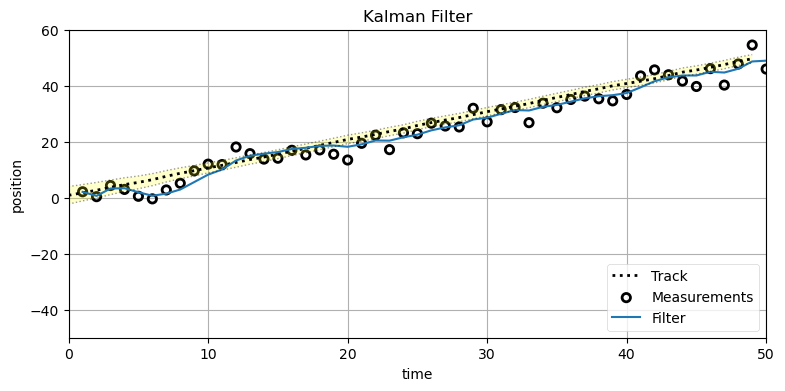

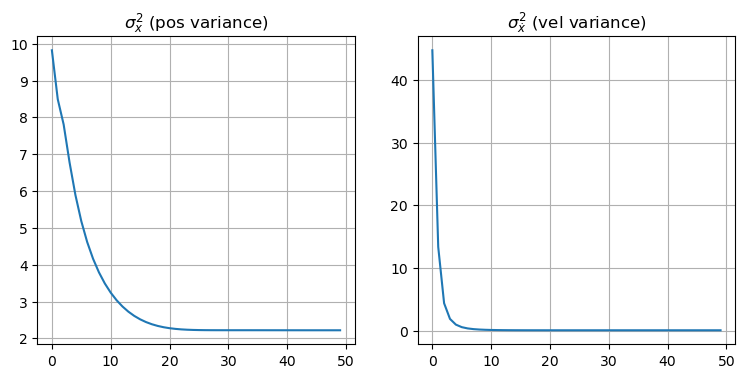

In [112]:
P = np.diag([500., 49.])
Ms, Ps = run(count=50, R=10, Q=0.01, P=P)

There is still a lot to learn, but we have implemented a Kalman filter using the same theory and equations as published by Rudolf Kalman! Code very much like this runs inside of your GPS, airliners, robots, and so on. 

The first plot plots the output of the Kalman filter against the measurements and the actual position of our dog (labelled *Track*). After the initial settling in period the filter should track the dog's position very closely. The yellow shaded portion between the black dotted lines shows 1 standard deviations of the filter's variance, which I explain in the next paragraph.

The next two plots show the variance of $x$ and of $\dot x$. I have plotted the diagonals of $\mathbf P$ over time. Recall that the diagonal of a covariance matrix contains the variance of each state variable. So $\mathbf P[0,0]$ is the variance of $x$, and $\mathbf P[1,1]$ is the variance of $\dot x$. You can see that we quickly converge to small variances for both. 

The covariance matrix $\mathbf P$ tells us the *theoretical* performance of the filter *assuming* everything we tell it is true. Recall that the standard deviation is the square root of the variance, and that approximately 68% of a Gaussian distribution occurs within one standard deviation. If at least 68% of the filter output is within one standard deviation  the filter may be performing well. In the top chart I have displayed the one standard deviation as the yellow shaded area between the two dotted lines. To my eye it looks like perhaps the filter is slightly exceeding that bounds, so the filter probably needs some tuning.

In the univariate chapter we filtered very noisy signals with much simpler code than the code above. However, realize that right now we are working with a very simple example - an object moving through 1-D space and one sensor. That is about the limit of what we can compute with the code in the last chapter. In contrast, we can implement very complicated, multidimensional filters with this code merely by altering our assignments to the filter's variables. Perhaps we want to track 100 dimensions in financial models. Or we have an aircraft with a GPS, INS, TACAN, radar altimeter, baro altimeter, and airspeed indicator, and we want to integrate all those sensors into a model that predicts position, velocity, and acceleration in 3D space. We can do that with the code in this chapter.

I want you to get a better feel for how the Gaussians change over time, so here is a 3D plot showing the Gaussians every 7th epoch (time step). Every 7th separates them enough so can see each one independently. The first Gaussian at $t=0$ is to the left.

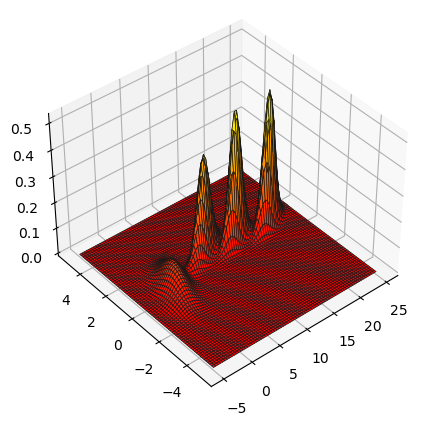

In [113]:
from kf_book.book_plots import set_figsize, figsize
from kf_book.nonlinear_plots import plot_gaussians

P = np.diag([3., 1.])
np.random.seed(3)
Ms, Ps = run(count=25, R=10, Q=0.01, P=P, do_plot=False)
with figsize(x=9, y=5):
    plot_gaussians(Ms[::7], Ps[::7], (-5,25), (-5, 5), 75)

## The Saver Class

In the `run()` method I wrote boilerplate code to save the results of the filter
```python
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
```

There's an easy way to avoid this. `filterpy.common` provides the `Saver` class which will save all attributes in the Kalman filter class each time `Saver.save()` is called. Let's see it in action and then we will talk about it more.

In [114]:
from filterpy.common import Saver
kf = pos_vel_filter([0, .1], R=R, P=P, Q=Q, dt=1.) 
s = Saver(kf)
for i in range(1, 6):
    kf.predict()
    kf.update([i])
    s.save()  # save the current state

The `Saver` object now contains lists of all the attributes of the KalmanFilter object. `kf.x` is the current state estimate of the filter. Therefore `s.x` contains the saved state estimate that was computed inside the loop:

In [115]:
s.x

[array([0.531, 0.304]),
 array([1.555, 0.763]),
 array([2.784, 1.036]),
 array([3.944, 1.105]),
 array([5.015, 1.086])]

You can see all the available attributes with the `keys` attribute:

In [116]:
s.keys

['alpha',
 'likelihood',
 'log_likelihood',
 'mahalanobis',
 'dim_x',
 'dim_z',
 'dim_u',
 'x',
 'P',
 'Q',
 'B',
 'F',
 'H',
 'R',
 '_alpha_sq',
 'M',
 'z',
 'K',
 'y',
 'S',
 'SI',
 '_I',
 'x_prior',
 'P_prior',
 'x_post',
 'P_post',
 '_log_likelihood',
 '_likelihood',
 '_mahalanobis',
 'inv']

There are many attributes there that we haven't discussed yet, but many should be familar.

At this point you could write code to plot any of these variables. However, it is often more useful to use `np.array` instead of lists. Calling `Saver.to_array()` will convert the lists into `np.array`. There is one caveat: if the shape of any of the attributes changes during the run, the `to_array` will raise an exception since `np.array` requires all of the elements to be of the same type and size. 

If you look at the keys again you'll see that `z` is one of the choices. This is promising; apparently the measurement `z` is saved for us. Let's plot it against the estimate.

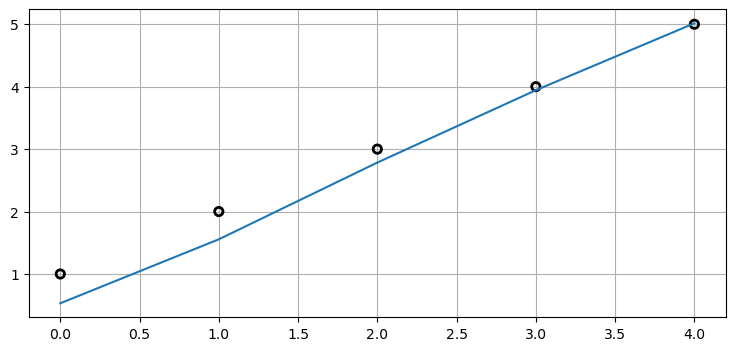

In [117]:
import matplotlib.pyplot as plt

s.to_array()
book_plots.plot_measurements(s.z);
plt.plot(s.x[:, 0]);

While I've demonstrated this with the `KalmanFilter` class, it will work with all filter classes implemented by `FilterPy`. It will probably work with any class you write as well, as it inspects the object to retrieve the attribute names. We will use this class throughout the book to keep the code readable and short. Using the `Saver` will slow down your code because a lot happens behind the scenes, but for learning and exploring the convience cannot be beat.

## The Kalman Filter Equations

We are now ready to learn how `predict()` and `update()` perform their computations. 

A word about notation. I'm a programmer, and I am used to code that reads

```python
x = x + 1
``` 

That is not an equation as the sides are not equal, but an *assignment*. If we wanted to write this in mathematical notation we'd write
$$x_k = x_{k-1} + 1$$

Kalman filter equations are littered with subscripts and superscripts to keep the equations mathematically consistent. I find this makes them extremely hard to read. In most of the book I opt for subscriptless assignments. As a programmer you should understand that I am showing you assignments which implement an algorithm that is to be executed step by step. I'll elaborate on this once we have a concrete example.

### Prediction Equations

The Kalman filter uses these equations to compute the *prior* - the predicted next state of the system. They compute the prior mean ($\bar{\mathbf x}$)  and covariance ($\bar{\mathbf P}$) of the system.

$$\begin{aligned}
\mathbf{\bar x} &= \mathbf{Fx} + \mathbf{Bu}\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$

$\underline{\textbf{Mean}}$

$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$

As a reminder, the linear equation $\mathbf{Ax} = \mathbf b$ represents a system of equations, where $\mathbf A$ holds the coefficients set of equations, $\mathbf x$ is the vector of variables. Performing the multiplication $\mathbf{Ax}$ computes the right hand side values for that set of equations, represented by $\mathbf b$.

If $\mathbf F$ contains the state transition for a given time step, then the product $\mathbf{Fx}$ computes the state after that transition. Easy! Likewise, $\mathbf B$ is the control function, $\mathbf u$ is the control input, so $\mathbf{Bu}$ computes the contribution of the controls to the state after the transition. Thus, the prior $\mathbf{\bar x}$ is computed as the sum of $\mathbf{Fx}$ and $\mathbf{Bu}$.

The equivalent univariate equation is

$$\bar\mu = \mu + \mu_{move}$$

If you perform the matrix multiplication $\mathbf{Fx}$ it generates this equation for $x$.

Let's make this explicit. Recall the value for $\mathbf F$ from the last chapter:

$$\mathbf F = \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}$$

Thus $\mathbf{\bar x} = \mathbf{Fx}$ corresponds to the set of linear equations:

$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$

$\underline{\textbf{Covariance}}$

$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$

This equation is not as easy to understand so we will spend more time on it. 

In univariate version of this equation is:

$$\bar\sigma^2 = \sigma^2 + \sigma^2_{move}$$

We add the variance of the movement to the variance of our estimate to reflect the loss of knowlege. We need to do the same thing here, except it isn't quite that easy with multivariate Gaussians. 

We can't simply write $\mathbf{\bar P} = \mathbf P + \mathbf Q$. In a multivariate Gaussians the state variables are *correlated*. What does this imply? Our knowledge of the velocity is imperfect, but we are adding it to the position with

$$\bar x = \dot x\Delta t + x$$

Since we do not have perfect knowledge of the value of $\dot x$ the sum $\bar x = \dot x\Delta t + x$ gains uncertainty. Because the positions and velocities are correlated we cannot simply add the covariance matrices. For example, if $\mathbf P$ and $\mathbf Q$ are diagonal matrices the sum would also be diagonal. But we know position is correlated to velocity so the off-diagonal elements should be non-zero. 

The correct equation is

$$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$$

Expressions in the form $\mathbf{ABA}^\mathsf T$ are common in linear algebra. You can think of it as *projecting* the middle term by the outer term. We will be using this many times in the rest of the book. I admit this may be a 'magical' equation to you. Let's explore it.

When we initialize $\mathbf P$ with

$$\mathbf P = \begin{bmatrix}\sigma^2_x & 0 \\ 0 & \sigma^2_v\end{bmatrix}$$


the value for $\mathbf{FPF}^\mathsf T$ is:

$$\begin{aligned}
\mathbf{FPF}^\mathsf T &= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\begin{bmatrix}\sigma^2_x & 0 \\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x&\sigma_v^2\Delta t\\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x +  \sigma_v^2\Delta t^2  &  \sigma_v^2\Delta t \\
\sigma_v^2\Delta t & \sigma^2_{v}\end{bmatrix}
\end{aligned}$$

The initial value for $\mathbf P$ had no covariance between the position and velocity.  Position is computed as $\dot x\Delta t + x$, so there is a correlation between the position and velocity. The multiplication $\mathbf{FPF}^\mathsf T$ computes a covariance of $\sigma_v^2 \Delta t$. The exact value is not important; you just need to recognize that $\mathbf{FPF}^\mathsf T$ uses the process model to automatically compute the covariance between the position and velocity!

Another way to think of this is to reflect on the $\mathbf{Fx}$ multiplication. That projected $\mathbf x$ forward in time. $\mathbf {FP}$ might seem to be the equivalent operation, but $\mathbf P$ is a matrix while $\mathbf x$ is a vector. The trailing $\mathbf F^\mathsf T$ term ensures that we multiply by both the rows and columns of $\mathbf F$. In the second line of the computation of $\mathbf{FPF}^\mathsf T$ we have the value for $\mathbf{FP}$. You can see that it is an upper triangular matrix because we haven't fully incorporated $\mathbf F$ into the multiplication.

If you have some experience with linear algebra and statistics, this may help. The covariance due to the prediction can be modeled as the expected value of the error in the prediction step, given by this equation. 

$$\begin{aligned}
\bar{\mathbf P} &= \mathbb E[(\mathbf{Fx - F\bar \mu})(\mathbf{Fx - F\bar\mu})^\mathsf T]\\
 &= \mathbf F\, \mathbb E[\mathbf{(x- \bar\mu)(x- \bar\mu)}^\mathsf T]\, \mathbf F^\mathsf T
\end{aligned}$$

Of course, $\mathbb E[\mathbf{(x- \bar\mu)(x- \bar\mu)}^\mathsf T]$ is just $\mathbf P$, giving us

$$\bar{\mathbf P} = \mathbf{FPF}^\mathsf T$$

Let's look at its effect. Here I use $\mathbf F$ from our filter and project the state forward 6/10ths of a second. I do this five times so you can see how $\mathbf{\bar P}$ continues to change. 

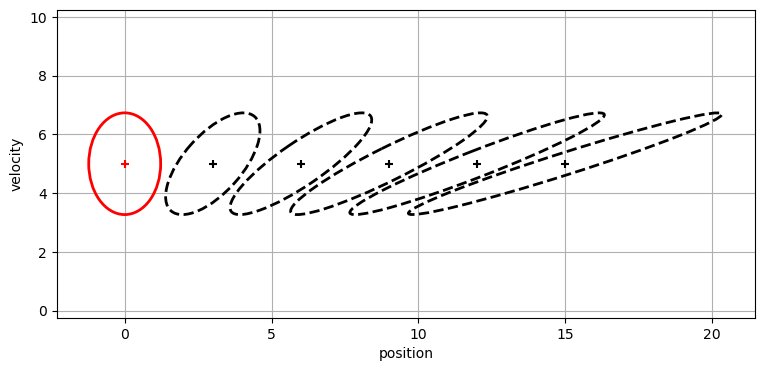

In [118]:
dt = 0.6
x = np.array([0., 5.])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[1.5, 0], [0, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(5):
    x = F @ x
    P = F @ P @ F.T
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
book_plots.set_labels(x='position', y='velocity')

You can see that with a velocity of 5 the position correctly moves 3 units in each 6/10ths of a second step. At each step the width of the ellipse is larger, indicating that we have lost information about the position due to adding $\dot x\Delta t$ to x at each step. The height has not changed - our system model says the velocity does not change, so the belief we have about the velocity cannot change. As time continues you can see that the ellipse becomes more and more tilted. Recall that a tilt indicates *correlation*. $\mathbf F$ linearly correlates $x$ with $\dot x$ with the expression $\bar x = \dot x \Delta t + x$. The $\mathbf{FPF}^\mathsf T$ computation correctly incorporates this correlation into the covariance matrix.

Here is an animation of this equation that allows you to change the design of $\mathbf F$ to see how it affects shape of $\mathbf P$. The `F00` slider affects the value of F[0, 0]. `covar` sets the intial covariance between the position and velocity($\sigma_x\sigma_{\dot x}$). I recommend answering these questions at a minimum

* what if $x$ is not correlated to $\dot x$? (set F01 to 0, the rest at defaults)
* what if $x = 2\dot x\Delta t + x_0$? (set F01 to 2, the rest at defaults)
* what if $x = \dot x\Delta t + 2x_0$? (set F00 to 2, the rest at defaults)
* what if $x = \dot x\Delta t$?  (set F00 to 0, the rest at defaults)

In [119]:
from ipywidgets import interact
from kf_book.book_plots import IntSlider, FloatSlider

def plot_FPFT(F00, F01, F10, F11, covar):   
    plt.figure()
    dt = 1.
    x = np.array((0, 0.))
    P = np.array(((1, covar), (covar, 2)))
    F = np.array(((F00, F01), (F10, F11)))
    plot_covariance_ellipse(x, P)
    plot_covariance_ellipse(x, F @ P @ F.T, ec='r')
    plt.gca().set_aspect('equal')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    #plt.title(str(F))
    plt.xlabel('position')
    plt.ylabel('velocity')
    plt.show()
                 
interact(plot_FPFT, 
         F00=IntSlider(value=1, min=0, max=2), 
         F01=FloatSlider(value=1, min=0, max=2, description='F01(dt)'),
         F10=FloatSlider(value=0, min=0, max=2),
         F11=FloatSlider(value=1, min=0, max=2),
         covar=FloatSlider(value=0, min=0, max=1));

interactive(children=(IntSlider(value=1, continuous_update=False, description='F00', max=2), FloatSlider(value…

(If you are reading this in a static form: instructions to run this online are here: https://git.io/vza7b). Or, go to binder using the link below, and open this notebook from there.

http://mybinder.org/repo/rlabbe/Kalman-and-Bayesian-Filters-in-Python

### Update Equations

The update equations look messier than the predict equations, but that is mostly due to the Kalman filter computing the update in measurement space. This is because measurements are not *invertible*. For example, consider a  sensor that gives the range to a target. It is impossible to convert a range into a position - an infinite number of positions in a circle will yield the same range. On the other hand, we can always compute the range (measurement) given a position (state).

Before I continue, recall that we are trying to do something very simple: choose a new estimate chosen somewhere between a measurement and a prediction, as in this chart:
<img src="./figs/residual_chart.png">

The equations will be complicated because the state has multiple dimensions, but this operations is what we are doing. Don't let the equations distract you from the simplicity of this idea.

$\underline{\textbf{System Uncertainty}}$

$\textbf{S} = \mathbf{H\bar PH}^\mathsf T + \mathbf R$

To work in measurement space the Kalman filter has to project the covariance matrix into measurement space. The math for this is $\mathbf{H\bar PH}^\mathsf T$, where $\mathbf{\bar P}$ is the *prior* covariance and $\mathbf H$ is the measurement function.


You should recognize this $\mathbf{ABA}^\mathsf T$ form - the prediction step used $\mathbf{FPF}^\mathsf T$ to update $\mathbf P$ with the state transition function. Here, we use the same form to update it with the measurement function. The linear algebra is changing the coordinate system for us. 

Once the covariance is in measurement space we need to account for the sensor noise. This is very easy  - we just add matrices. The result is variously called the *system uncertainty* or *innovation covariance*.

If you ignore the $\mathbf H$ term this equation is the equivalent to the denominator in the univariate equation for the Kalman gain:

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$

Compare the equations for the system uncertainty and the covariance

$$\begin{aligned}
\mathbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$

In each equation $\mathbf P$ is put into a different space with either the function $\mathbf H$ or $\mathbf F$. Then we add the noise matrix associated with that space.

$\underline{\textbf{Kalman Gain}}$

$\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$

Look back at the residual diagram. Once we have a prediction and a measurement we need to select an estimate somewhere between the two. If we have more certainty about the measurement the estimate will be closer to it. If instead we have more certainty about the prediction then the estimate will be closer to it. 

In the univariate chapter we scaled the mean using this equation

$$
\mu =\frac{\bar\sigma^2 \mu_z + \sigma_\mathtt{z}^2 \bar\mu} {\bar\sigma^2 + \sigma_\mathtt{z}^2}$$

which we simplified to

$$\mu = (1-K)\bar\mu + K\mu_\mathtt{z}$$

which gave us

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$

$K$ is the *Kalman gain*, and it is a real number between 0 and 1. Ensure you understand how it selects a mean somewhere between the prediction and measurement. The Kalman gain is a *percentage* or *ratio* - if K is .9 it takes 90% of the measurement and 10% of the prediction. 

For the multivariate Kalman filter $\mathbf K$ is a vector, not a scalar. Here is the equation again: $\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$. Is this a *ratio*? We can think of the inverse of a matrix as linear algebra's way of finding the reciprocal. Division is not defined for matrices, but it is useful to think of it in this way. So we can read the equation for $\textbf{K}$ as meaning

$$\begin{aligned} \mathbf K &\approx \frac{\mathbf{\bar P}\mathbf H^\mathsf T}{\mathbf{S}} \\
\mathbf K &\approx \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T
\end{aligned}$$

The Kalman gain equation computes a ratio based on how much we trust the prediction vs the measurement. We did the same thing in every prior chapter. The equation is complicated because we are doing this in multiple dimensions via matrices, but the concept is simple. The $\mathbf H^\mathsf T$ term is less clear, I'll explain it soon. If you ignore that term the equation for the Kalman gain is the same as the univariate case: divide the uncertainty of the prior with the of the sum of the uncertainty of the prior and measurement.

$\underline{\textbf{Residual}}$

$\mathbf y = \mathbf z - \mathbf{H\bar{x}}$

This is an easy one as we've covered this equation while designing the measurement function $\mathbf H$. Recall that the measurement function converts a state into a measurement. So $\mathbf{Hx}$ converts $\mathbf x$ into an equivalent measurement. Once that is done, we can subtract it from the measurement $\mathbf z$ to get the residual - the difference between the measurement and prediction.

The univariate equation is

$$y = z - \bar x$$

and clearly computes the same thing, but only in one dimension.

$\underline{\textbf{State Update}}$

$\mathbf x = \mathbf{\bar x} + \mathbf{Ky}$

We select our new state to be along the residual, scaled by the Kalman gain. The scaling is performed by $\mathbf{Ky}$, which both scales the residual and converts it back into state space with the $\mathbf H^\mathsf T$ term which is in $\mathbf K$. This is added to the prior, yielding the equation: $\mathbf x =\mathbf{\bar x} + \mathbf{Ky}$. Let me write out $\mathbf K$ so we can see the entire computation:

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} + \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}\mathbf y \\
&\approx \mathbf{\bar x} + \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T \mathbf y
\end{aligned}$$

Perhaps a better way to *see* the ratio is to rewrite the estimate equation:

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} +\mathbf K(\mathbf z - \mathbf{H\bar x}) \\
&= (\mathbf I - \mathbf{KH})\mathbf{\bar x} + \mathbf{Kz}
\end{aligned}$$

The similarity between this and the univariate form should be obvious:
$$\mu = (1-K)\bar\mu + K\mu_\mathtt{z}$$

$\underline{\textbf{Covariance Update}}$

$\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}$

$\mathbf{I}$ is the identity matrix, and is the way we represent $1$ in multiple dimensions. $\mathbf H$ is our measurement function, and is a constant.  We can think of the equation as $\mathbf P = (1-c\mathbf K)\mathbf P$. $\mathbf K$ is our ratio of how much prediction vs measurement we use. If $\mathbf K$ is large then $(1-\mathbf{cK})$ is small, and $\mathbf P$ will be made smaller than it was. If $\mathbf K$ is small, then $(1-\mathbf{cK})$ is large, and $\mathbf P$ will be relatively larger. This means that we adjust the size of our uncertainty by some factor of the Kalman gain.

This equation can be numerically unstable and I don't use it in FilterPy. The subtraction can destroy symmetry and lead to floating point errors over time. Later I'll share more complicated but numerically stable forms of this equation.

### An Example not using FilterPy

FilterPy hides the details of the implementation from us. Normally you will appreciate this, but let's implement the last filter without FilterPy. To do so we need to define our matrices as variables, and then implement the Kalman filter equations explicitly.

Here we initialize our matrices:

In [120]:
dt = 1.
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

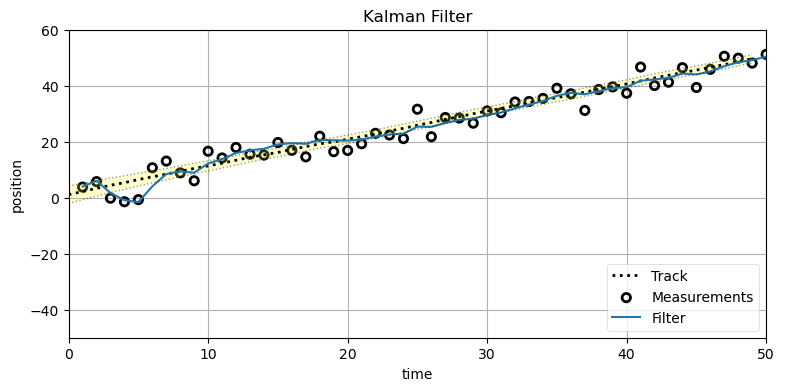

In [121]:
from scipy.linalg import inv

count = 50
track, zs = compute_dog_data(R_var, Q_var, count)
xs, cov = [], []
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov, plot_P=False)

The results are identical to the FilterPy version. Which you prefer is up to you. I prefer not polluting my namespace with variables such as `x`, `P`, and so on; `dog_filter.x` is, to me, more readable.

More importantly, this example requires you to remember and program the equations for the Kalman filter. Sooner or later you will make a mistake. FilterPy's version ensures that your code will be correct. On the other hand, if you make a mistake in your definitions, such as making $\mathbf H$ a column vector instead of a row vector, FilterPy's error message will be harder to debug than this explicit code. 

FilterPy's KalmanFilter class provides additional functionality such as smoothing, batch processing, faded memory filtering, computation of the maximum likelihood function, and more. You get all of this functionality without having to explicitly program it.

### Summary

We have learned the Kalman filter equations. Here they are all together for your review. There was a lot to learn, but I hope that as you went through each you recognized it's kinship with the equations in the univariate filter. In the *Kalman Math* chapter I will show you that if we set the dimension of $\mathbf x$ to one that these equations revert back to the equations for the univariate filter. This is not "like" the univariate filter - it is a multidimensional implementation of it.

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{\bar x} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{\bar P} &= \mathbf{FP{F}}^\mathsf T + \mathbf Q \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
\textbf{y} &= \mathbf z - \mathbf{H \bar x} \\
\mathbf x &=\mathbf{\bar x} +\mathbf{K\textbf{y}} \\
\mathbf P &= (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}
\end{aligned}
$$

I want to share a form of the equations that you will see in the literature. There are many different notation systems used, but this gives you an idea of what to expect.

 $$
\begin{aligned}
\hat{\mathbf x}_{k\mid k-1} &= \mathbf F_k\hat{\mathbf x}_{k-1\mid k-1} + \mathbf B_k \mathbf u_k  \\
\mathbf P_{k\mid k-1} &=  \mathbf F_k \mathbf P_{k-1\mid k-1} \mathbf F_k^\mathsf T + \mathbf Q_k \\        	
\tilde{\mathbf y}_k &= \mathbf z_k - \mathbf H_k\hat{\mathbf x}_{k\mid k-1}\\
\mathbf{S}_k &= \mathbf H_k \mathbf P_{k\mid k-1} \mathbf H_k^\mathsf T + \mathbf R_k \\
\mathbf K_k &= \mathbf P_{k\mid k-1}\mathbf H_k^\mathsf T \mathbf{S}_k^{-1}\\
\hat{\mathbf x}_{k\mid k} &= \hat{\mathbf x}_{k\mid k-1} + \mathbf K_k\tilde{\mathbf y}_k\\
\mathbf P_{k|k} &= (I - \mathbf K_k \mathbf H_k) \mathbf P_{k|k-1}
\\\end{aligned}
$$

This notation uses the Bayesian $a\mid b$ notation, which means $a$ given the evidence of $b$. The hat means estimate. Thus $\hat{\mathbf x}_{k\mid k}$ means the estimate of the state $\mathbf x$ at step $k$ (the first $k$) given the evidence from step $k$ (the second $k$). The posterior, in other words. $\hat{\mathbf x}_{k\mid k-1}$ means the estimate for the state $\mathbf x$ at step $k$ given the estimate from step $k - 1$. The prior, in other words. 

This notation, copied from [Wikipedia](https://en.wikipedia.org/wiki/Kalman_filter#Details) [[1]](#[wiki_article]), allows a mathematician to express himself exactly. In formal publications presenting new results this precision is necessary. As a programmer I find it fairly unreadable. I am used to thinking about variables changing state as a program runs, and do not use a different variable name for each new computation. There is no agreed upon format in the literature, so each author makes different choices. I find it challenging to switch quickly between books and papers, and so have adopted my admittedly less precise notation. Mathematicians may write scathing emails to me, but I hope programmers and students will rejoice at my simplified notation.

The **Symbology** Appendix lists the notation used by various authors. This brings up another difficulty. Different authors use different variable names. $\mathbf x$ is fairly universal, but after that it is anybody's guess. For example, it is common to use $\mathbf{A}$ for what I call $\mathbf F$. You must read carefully, and hope that the author defines their variables (they often do not).

If you are a programmer trying to understand a paper's equations, I suggest starting by removing all of the superscripts, subscripts, and diacriticals, replacing them with a single letter. If you work with equations like this every day this is superfluous advice, but when I read I am usually trying to understand the flow of computation. To me it is far more understandable to remember that $P$ in this step represents the updated value of $P$ computed in the last step, as opposed to trying to remember what $P_{k-1}(+)$ denotes, and what its relation to $P_k(-)$ is, if any, and how any of that relates to the completely different notation used in the paper I read 5 minutes ago.

## Exercise: Show Effect of Hidden Variables

In our filter velocity is a hidden variable. How would a filter perform if we did not use velocity in the state?

Write a Kalman filter that uses the state $\mathbf x=\begin{bmatrix}x\end{bmatrix}$ and compare it against a filter that uses $\mathbf x=\begin{bmatrix}x & \dot x\end{bmatrix}^\mathsf T$.

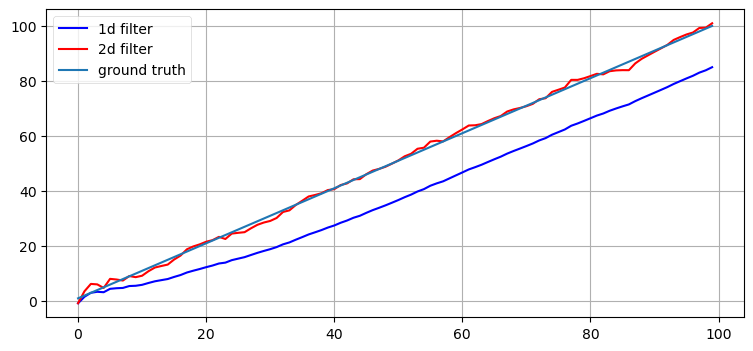

In [166]:
# your code here 
from numpy.random import seed 
seed(303)
def pos_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=1, dim_z=1, dim_u=0)
    kf.x = np.array([x]) # location and velocity
    kf.F = np.array([[1.]])  # state transition matrix
    kf.H = np.array([[1.]])    # Measurement function
    kf.B = np.array([1])
    kf.R *= R                     # measurement uncertainty
    kf.P *= P
    kf.Q *= Q
    return kf



def plot_results(x0, v0, P, R, Q):
    
    xs = []
    xs_1d = []
    xs_2d = []
    
    f1d = pos_filter(x=x0, P=P, R=R, Q=Q)
    f2d = pos_vel_filter(x=(x0, v0), P=P, R=R, Q=Q)
    for _ in range(100):
        x0 += v0
        xs.append(x0)
        f1d.predict()
        f2d.predict()
        z = x0 + randn()*np.sqrt(R) # measurement
        f1d.update(z)
        f2d.update(z)
        xs_1d.append(f1d.x[0])
        xs_2d.append(f2d.x[0])

    plt.plot(xs_1d, label="1d filter", color="blue")
    plt.plot(xs_2d, label="2d filter", color="red")
    plt.plot(xs, label="ground truth")
    plt.legend()
    plt.show()

plot_results(x0=0, v0=1., P=50., R=5., Q=.02 )

### Solution

We've already implemented a Kalman filter for position and velocity, so I will provide the code without much comment, and then plot the result.

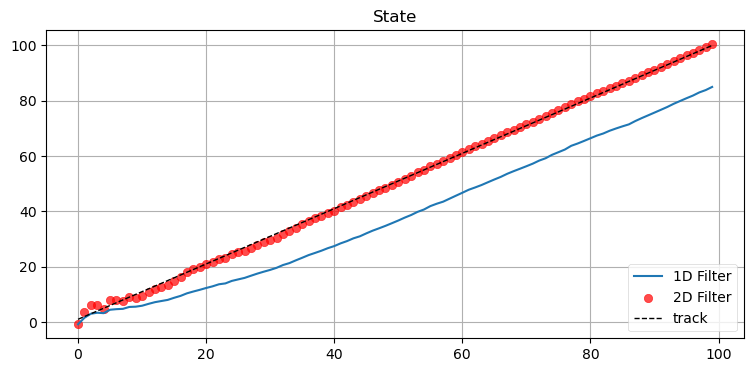

In [144]:
from math import sqrt
from numpy.random import randn
from numpy.random import seed 
seed(303)
def univariate_filter(x0, P, R, Q):
    f = KalmanFilter(dim_x=1, dim_z=1, dim_u=1)
    f.x = np.array([[x0]])
    f.P *= P
    f.H = np.array([[1.]])
    f.F = np.array([[1.]])
    f.B = np.array([[1.]])
    f.Q *= Q
    f.R *= R
    return f

def plot_1d_2d(xs, xs1d, xs2d):
    plt.plot(xs1d, label='1D Filter')
    plt.scatter(range(len(xs2d)), xs2d, c='r', alpha=0.7, label='2D Filter')
    plt.plot(xs, ls='--', color='k', lw=1, label='track')
    plt.title('State')
    plt.legend(loc=4)
    plt.show()
    
def compare_1D_2D(x0, P, R, Q, vel, u=None):
    # storage for filter output
    xs, xs1, xs2 = [], [], []

    # 1d KalmanFilter
    f1D = univariate_filter(x0, P, R, Q)

    #2D Kalman filter
    f2D = pos_vel_filter(x=(x0, vel), P=P, R=R, Q=0)
    if np.isscalar(u):
        u = [u]
    pos = 0 # true position
    for i in range(100):
        pos += vel
        xs.append(pos)

        # control input u - discussed below
        f1D.predict(u=u)
        f2D.predict()
        
        z = pos + randn()*sqrt(R) # measurement
        f1D.update(z)
        f2D.update(z)
        
        xs1.append(f1D.x[0])
        xs2.append(f2D.x[0])
    plt.figure()
    plot_1d_2d(xs, xs1, xs2)

compare_1D_2D(x0=0, P=50., R=5., Q=.02, vel=1.) 

### Discussion

The filter that incorporates velocity into the state produces much better estimates than the filter that only tracks position. The univariate filter has no way to estimate the velocity or change in position, so it lags the tracked object. 

In the univarate Kalman filter chapter we had a control input `u` to the predict equation:

```python
    def predict(self, u=0.0):
        self.x += u
        self.P += self.Q
```

Let's try specifying the control input:

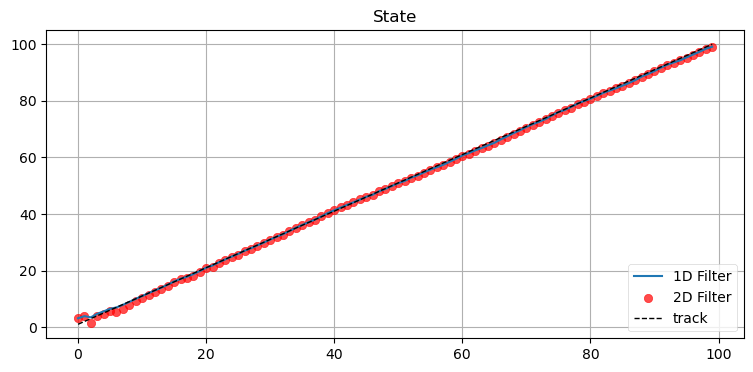

In [167]:
compare_1D_2D(x0=0, P=50., R=5., Q=.02, vel=1., u=1.) 

Here the performance of the two filters are similar, and perhaps the univariate filter is tracking more closely. But let's see what happens when the actual velocity `vel` is different from the control input `u`:

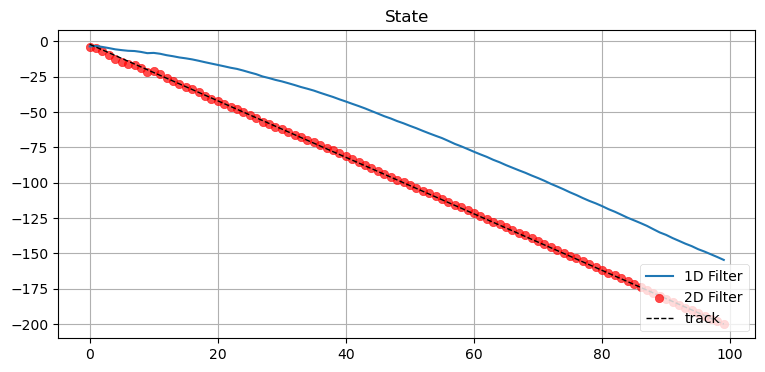

In [168]:
compare_1D_2D(x0=0, P=50., R=5., Q=.02, vel=-2., u=1.) 

If we are tracking a robot which we are also controlling the univariate filter can do a very good job because the control input allows the filter to make an accurate prediction. But if we are tracking passively the control input is not much help unless we can make an accurate *apriori* guess as to the velocity. This is rarely possible.

## How Velocity is Calculated

I haven't explained how the filter computes the velocity, or any hidden variable. If we plug in the values we calculated for each of the filter's matrices we can see what happens.

First we need to compute the system uncertainty.

$$\begin{aligned}
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
&= \begin{bmatrix} 1 & 0\end{bmatrix}
\begin{bmatrix}\sigma^2_x & \sigma_{xv} \\ \sigma_{xv} & \sigma^2_v\end{bmatrix}
\begin{bmatrix} 1 \\ 0\end{bmatrix} + \begin{bmatrix}\sigma_z^2\end{bmatrix}\\
&= \begin{bmatrix}\sigma_x^2 & \sigma_{xv}\end{bmatrix}\begin{bmatrix} 1 \\ 0\end{bmatrix}+ \begin{bmatrix}\sigma_z^2\end{bmatrix} \\
&= \begin{bmatrix}\sigma_x^2 +\sigma_z^2\end{bmatrix}
\end{aligned}$$

Now that we have $\mathbf S$ we can find the value for the Kalman gain:
$$\begin{aligned}
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
&= \begin{bmatrix}\sigma^2_x & \sigma_{xv} \\ \sigma_{xv} & \sigma^2_v\end{bmatrix}
\begin{bmatrix} 1 \\ 0\end{bmatrix}
\begin{bmatrix}\frac{1}{\sigma_x^2 +\sigma_z^2}\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x  \\ \sigma_{xv}\end{bmatrix}
\begin{bmatrix}\frac{1}{\sigma_x^2 +\sigma_z^2}\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x/(\sigma_x^2 +\sigma_z^2)  \\ \sigma_{xv}/(\sigma_x^2 +\sigma_z^2)\end{bmatrix}
\end{aligned}
$$

In other words, the Kalman gain for $x$ is 

$$K_x = \frac{VAR(x)}{VAR(x)+VAR(z)}$$

This should be very familiar to you from the univariate case. 

The Kalman gain for the velocity $\dot x$ is
$$K_{\dot x} = \frac{COV(x, \dot x)}{VAR(x)+VAR(z)}$$

What is the effect of this? Recall that we compute the state as 

$$\begin{aligned}\mathbf x 
&=\mathbf{\bar x}+\mathbf K(z-\mathbf{Hx)} \\
&= \mathbf{\bar x}+\mathbf Ky\end{aligned}$$

Here the residual $y$ is a scalar. Therefore it is multiplied into each element of $\mathbf K$. Therefore we have

$$\begin{bmatrix}x \\ \dot x\end{bmatrix}=\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} + \begin{bmatrix}K_x \\ K_{\dot x}\end{bmatrix}y$$

Which gives this system of equations: 

$$\begin{aligned}x& = \bar x + yK_x\\
\dot x &= \bar{\dot x} + yK_{\dot x}\end{aligned}$$

The prediction $\bar x$ was computed as $x + \bar x \Delta t$. If the prediction was perfect then the residual will be $y=0$ (ignoring noise in the measurement) and the velocity estimate will be unchanged. On the other hand, if the velocity estimate was very bad then the prediction will be very bad, and the residual will be large: $y >> 0$. In this case we update the velocity estimate with $yK_{\dot x}$. $K_{\dot x}$ is proportional to $COV(x,\dot x)$. Therefore the velocity is updated by the error in the position times the value proportional to the covariance between the position and velocity. The higher the correlation the larger the correction. 

To bring this full circle, $COV(x,\dot x)$ are the off-diagonal elements of $\mathbf P$. Recall that those values were computed with $\mathbf{FPF}^\mathsf T$. So the covariance of position and velocity is computed during the predict step. The Kalman gain for the velocity is proportional to this covariance, and we adjust the velocity estimate based on how inaccurate it was during the last epoch times a value proportional to this covariance. 

In summary, these linear algebra equations may be unfamiliar to you, but computation is actually very simple. It is essentially the same computation that we performed in the g-h filter. Our constants are different in this chapter because we take the noise in the process model and sensors into account, but the math is the same.

## Adjusting the Filter

Let's start varying our parameters to see the effect of various changes. This is a very normal thing to be doing with Kalman filters. It is difficult, and often impossible to exactly model our sensors. An imperfect model means imperfect output from our filter. Engineers spend a lot of time tuning Kalman filters so that they perform well with real world sensors. We will spend time now to learn the effect of these changes. As you learn the effect of each change you will develop an intuition for how to design a Kalman filter. Designing a Kalman filter is as much art as science. We are modeling a physical system using math, and models are imperfect.

Let's look at the effects of the measurement noise $\mathbf R$ and process noise $\mathbf Q$. We will want to see the effect of different settings for $\mathbf R$ and $\mathbf Q$, so I have given the measurements a variance of 225 meters squared. That is very large, but it magnifies the effects of various design choices on the graphs, making it easier to recognize what is happening. Our first experiment holds $\mathbf R$ constant while varying $\mathbf Q$.

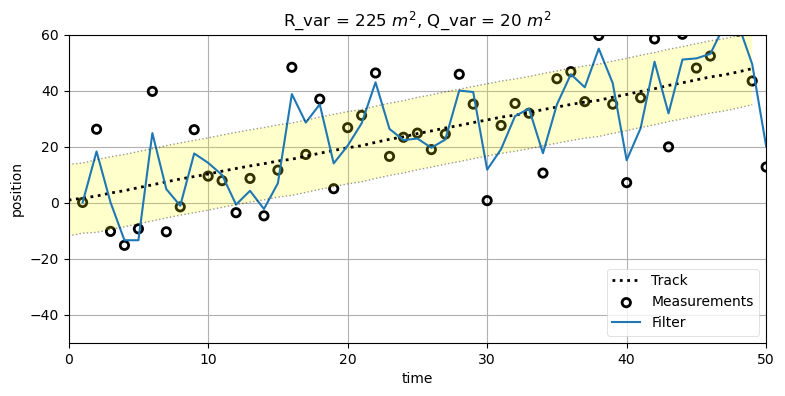

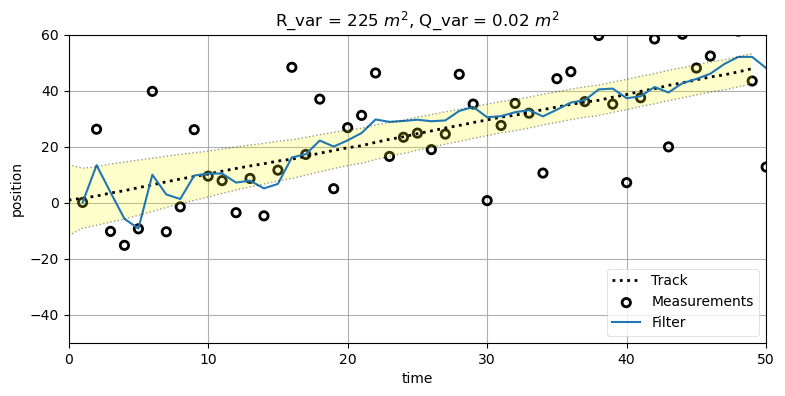

In [169]:
from numpy.random import seed
seed(2)
trk, zs = compute_dog_data(z_var=225, process_var=.02, count=50)

run(track=trk, zs=zs, R=225, Q=200, P=P, plot_P=False, 
    title='R_var = 225 $m^2$, Q_var = 20 $m^2$')
run(track=trk, zs=zs, R=225, Q=.02, P=P, plot_P=False, 
    title='R_var = 225 $m^2$, Q_var = 0.02 $m^2$');

The filter in the first plot should follow the noisy measurement closely. In the second plot the filter should vary from the measurement quite a bit, and be much closer to a straight line than in the first graph. Why does ${\mathbf Q}$ affect the plots this way?

Let's remind ourselves of what the term *process uncertainty* means. Consider the problem of tracking a ball. We can accurately model its behavior in a vacuum with math, but with wind, varying air density, temperature, and a spinning ball with an imperfect surface our model will diverge from reality. 

In the first case we set `Q_var=20 m^2`, which is quite large. In physical terms this is telling the filter "I don't trust my motion prediction step" as we are saying that the variance in the velocity is 20. Strictly speaking, we are telling the filter there is a lot of external noise that we are not modeling with $\small{\mathbf F}$, but the upshot of that is to not trust the motion prediction step. The filter will be computing velocity ($\dot x$), but then mostly ignoring it because we are telling the filter that the computation is extremely suspect. Therefore the filter has nothing to trust but the measurements, and thus it follows the measurements closely. 

In the second case we set `Q_var=0.02 m^2`, which is quite small. In physical terms we are telling the filter "trust the prediction, it is really good!". More strictly this actually says there is very small amounts of process noise (variance 0.02 $m^2$), so the process model is very accurate. So the filter ends up ignoring some of the measurement as it jumps up and down, because the variation in the measurement does not match our trustworthy velocity prediction.

Now let's set `Q_var` to $0.2\, m^2$, and bump `R_var` up to $10,000\, m^2$. This is telling the filter that the measurement noise is very large. 

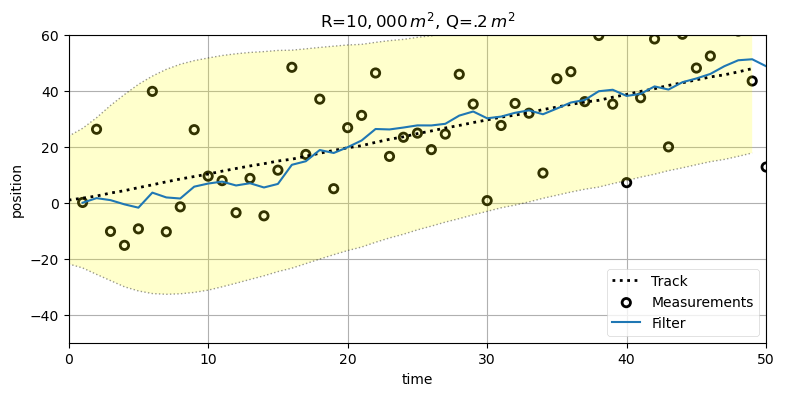

In [148]:
run(track=trk, zs=zs, R=10000, Q=.2, P=P, plot_P=False, 
    title='R=$10,000\, m^2$, Q=$.2\, m^2$');

The effect of this can be subtle. We have created an suboptimal filter because the actual measurement noise variance is 225 $m^2$, not 10,000 $m^2$. By setting the filter's noise variance so high we force the filter to favor the prediction over the measurement. This can lead to apparently very smooth and good looking results. In the chart above the track may look extremely good to you since it follows the ideal path very closely. But, the 'great' behavior at the start should give you pause - the filter has not converged yet ($\mathbf P$ is still large) so it should not be able to be so close to the actual position. We can see that $\mathbf P$ has not converged because the entire chart is colored with the yellow background denoting the size of $\mathbf P$. Let's see the result of a bad initial guess for the position by guessing the initial position to be 50 m and the initial velocity to be 1 m/s.

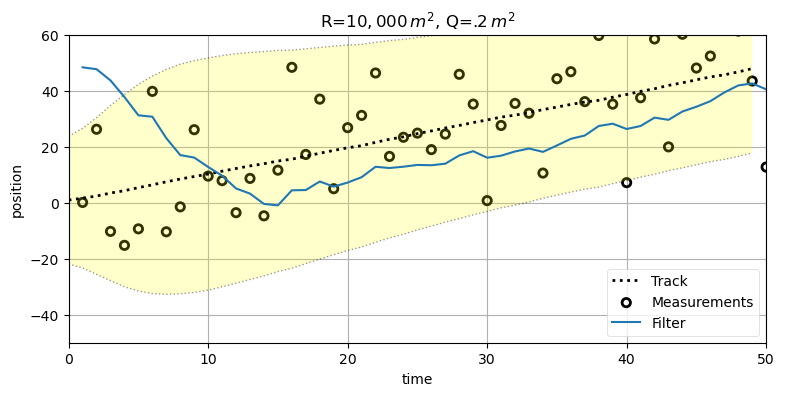

In [149]:
run(track=trk, zs=zs, R=10000, Q=.2, P=P, plot_P=False,
    x0=np.array([50., 1.]), 
    title='R=$10,000\, m^2$, Q=$.2\, m^2$');

Here we can see that the filter cannot acquire the track. This happens because even though the filter is getting reasonably good measurements it assumes that the measurements are bad, and eventually predicts forward from a bad position at each step. If you think that perhaps that bad initial position would give similar results for a smaller measurement noise, let's set it back to the correct value of 225 $m^2$.

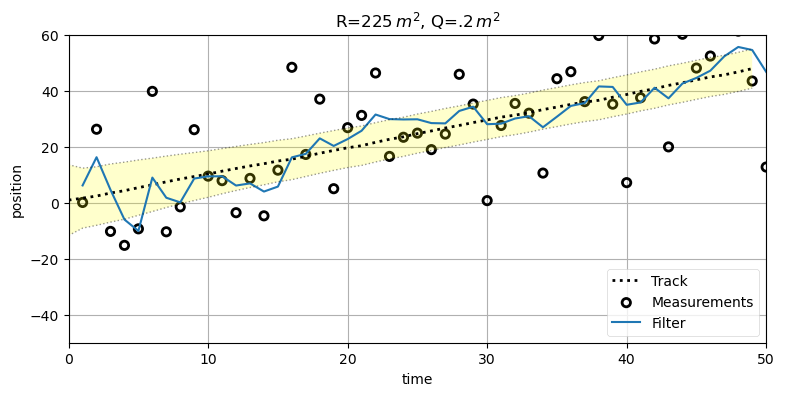

In [150]:
run(track=trk, zs=zs, R=225, Q=.2, P=P, plot_P=False, 
    x0=np.array([20., 1.]),
    title='R=$225\, m^2$, Q=$.2\, m^2$');

Here we see that the filter initially struggles for several iterations to acquire the track, but then it accurately tracks our dog. In fact, this is nearly optimum - we have not designed $\mathbf Q$ optimally, but $\mathbf R$ is optimal. A rule of thumb for $\mathbf Q$ is to set it between $\frac{1}{2}\Delta a$ to $\Delta a$, where $\Delta a$ is the maximum amount that the acceleration will change between sample periods. This only applies for the assumption we are making in this chapter - that acceleration is constant and uncorrelated between each time period. In the Kalman Math chapter we will discuss several different ways of designing $\mathbf Q$.

To some extent you can get similar looking output by varying either ${\mathbf R}$ or ${\mathbf Q}$, but I urge you to not 'magically' alter these until you get output that you like. Always think about the physical implications of these assignments, and vary ${\mathbf R}$ and/or ${\mathbf Q}$ based on your knowledge of the system you are filtering. Back that up with extensive simulations and/or trial runs of real data.

## A Detailed Examination of the Covariance Matrix

Let's start by revisiting plotting a track. I've hard coded the data and noise in `zs_var_275` to avoid being at the mercy of the random number generator, which might generate data that does not illustrate what I want to talk about. I will start with `P=500`.

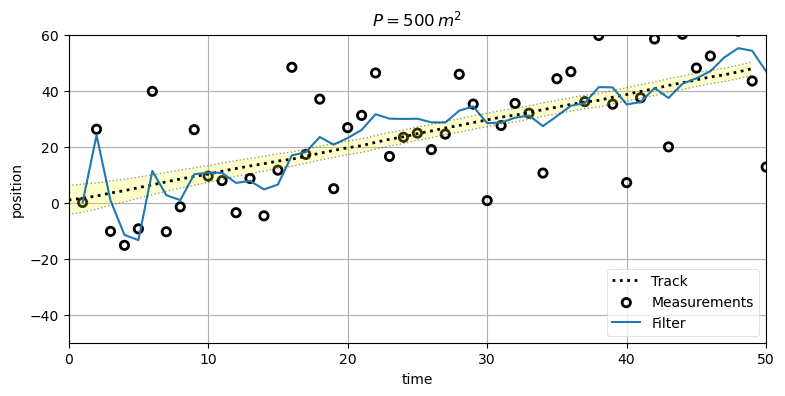

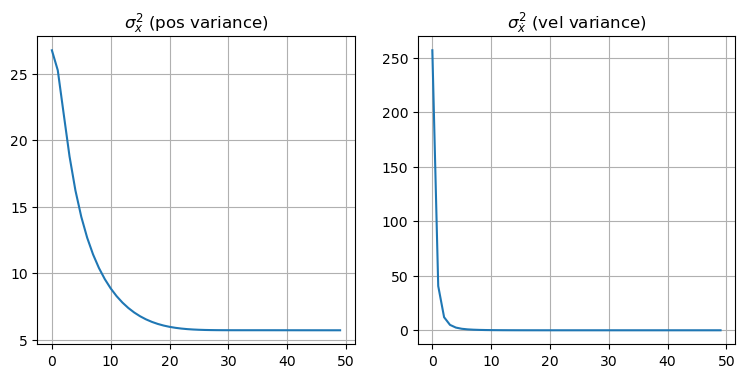

In [151]:
import kf_book.mkf_internal as mkf_internal

var = 27.5
data = mkf_internal.zs_var_275()
run(track=trk, zs=zs, R=var, Q=.02, P=500., plot_P=True, 
    title='$P=500\, m^2$');

Looking at the output we see a very large spike in the filter output at the beginning. We set $\text{P}=500\, \mathbf{I}_2$ (this is shorthand notation for a 2x2 diagonal matrix with 500 in the diagonal). We now have enough information to understand what this means, and how the Kalman filter treats it. The 500 in the upper left hand corner corresponds to $\sigma^2_x$; therefore we are saying the standard deviation of `x` is $\sqrt{500}$, or roughly 22.36 m. Roughly 99% of the samples occur withing $3\sigma$, therefore $\sigma^2_x=500$ is telling the Kalman filter that the prediction (the prior) could be up to 67 meters off. That is a large error, so when the measurement spikes the Kalman filter distrusts its own estimate and jumps wildly to try to incorporate the measurement. Then, as the filter evolves $\mathbf P$ quickly converges to a more realistic value.

Let's look at the math behind this. The equation for the Kalman gain is

$$\mathbf K = \mathbf{\bar P} \mathbf H^\mathsf T\mathbf{S}^{-1} \approx \frac{\mathbf{\bar P}\mathbf H^\mathsf T}{\mathbf{S}} 
\approx \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T
$$

It is a ratio of the uncertainty of the prediction vs measurement. Here the uncertainty in the prediction is large, so $\mathbf K$ is large (near 1 if this was a scalar). $\mathbf K$ is multiplied by the residual $\textbf{y} = \mathbf z - \mathbf{H \bar x}$, which is the measurement minus the prediction, so a large $\mathbf K$ favors the measurement. Therefore if $\mathbf P$ is large relative to the sensor uncertainty $\mathbf R$ the filter will form most of the estimate from the measurement. 


Now let us see the effect of a smaller initial value of $\mathbf P = 1.0\, \mathbf{I}_2$.

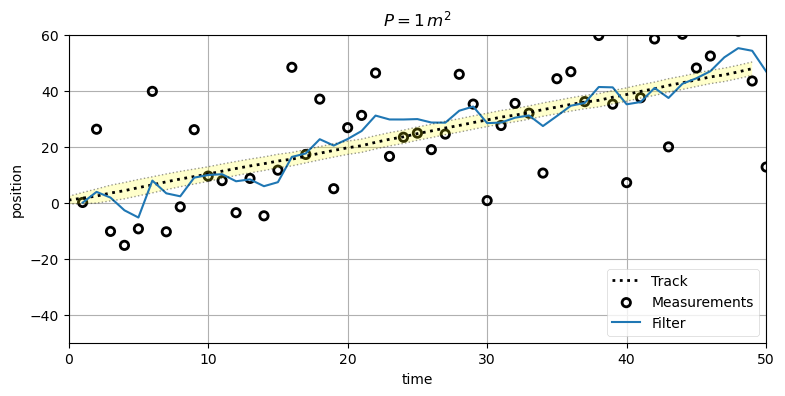

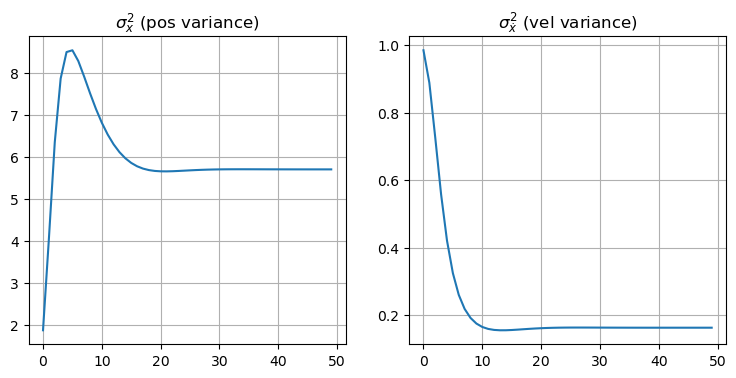

In [152]:
run(track=trk, zs=zs, R=var, Q=.02, P=1., plot_P=True, 
    title='$P=1\, m^2$');

This *looks* good at first blush. The plot does not have the spike that the former plot did; the filter starts tracking the measurements and doesn't take any time to settle to the signal. However, if we look at the plots for P you can see that there is an initial spike for the variance in position, and that it never really converges. Poor design leads to a long convergence time, and suboptimal results. 

So despite the filter tracking very close to the actual signal we cannot conclude that the 'magic' is to use a small $\mathbf P$. Yes, this will avoid having the Kalman filter take time to accurately track the signal, but if we are truly uncertain about the initial measurements this can cause the filter to generate very bad results. If we are tracking a living object we are probably very uncertain about where it is before we start tracking it. On the other hand, if we are filtering the output of a thermometer, we are as certain about the first measurement as the 1000th. For your Kalman filter to perform well you must set $\mathbf P$ to a value that truly reflects your knowledge about the data. 

Let's see the result of a bad initial estimate coupled with a very small $\mathbf P$. We will set our initial estimate at x = 100 m (whereas the dog actually starts at 0m), but set `P=1` m$^2$. This is clearly an incorrect value for $\mathbf P$ as the estimate is off by 100 m but we tell the filter that it the $3\sigma$ error is 3 m.

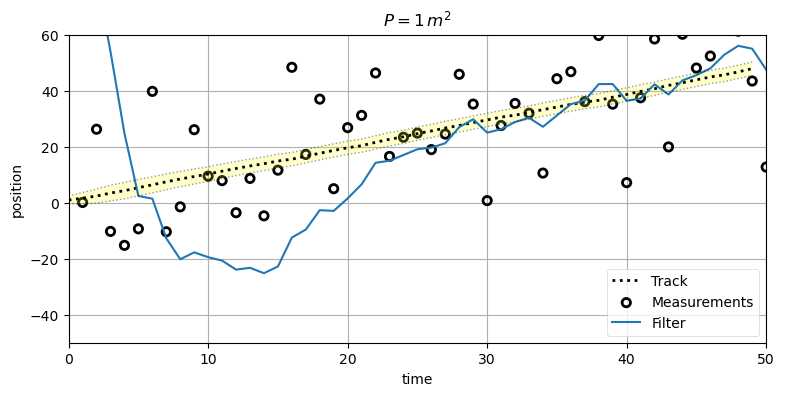

In [153]:
x = np.array([100., 0.])
run(track=trk, zs=zs, R=var, Q=.02, P=1., x0=x,
    plot_P=False, title='$P=1\, m^2$');

We can see that the initial estimates are terrible and that it takes the filter a long time to start converging onto the signal . This is because we told the Kalman filter that we strongly believe in our initial estimate of 100 m and were incorrect in that belief.

Now, let's provide a more reasonable value for `P` and see the difference.

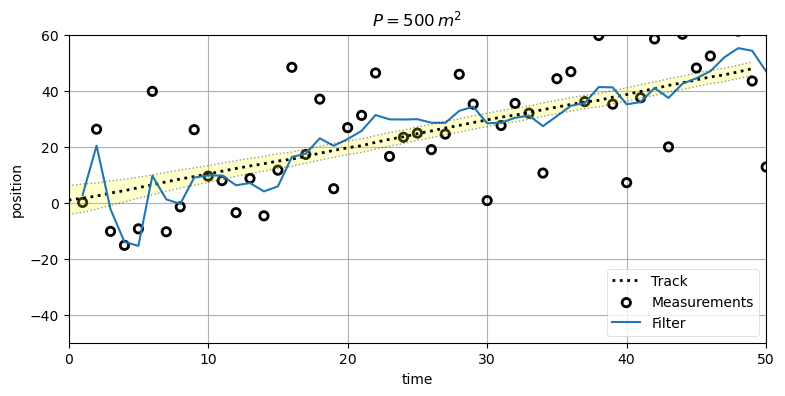

In [154]:
x = np.array([100., 0.])
run(track=trk, zs=zs, R=var, Q=.02, P=500., x0=x,
   plot_P=False, title='$P=500\, m^2$');

In this case the Kalman filter is very uncertain about the initial state, so it converges onto the signal much faster. It is producing good output after only 5 to 6 epochs. With the theory we have developed so far this is about as good as we can do. However, this scenario is a bit artificial; if we do not know where the object is when we start tracking we do not initialize the filter to some arbitrary value, such as 0 m or 100 m. I address this in the **Filter Initialization** section below.

Let's do another Kalman filter for our dog, and this time plot the covariance ellipses on the same plot as the position.

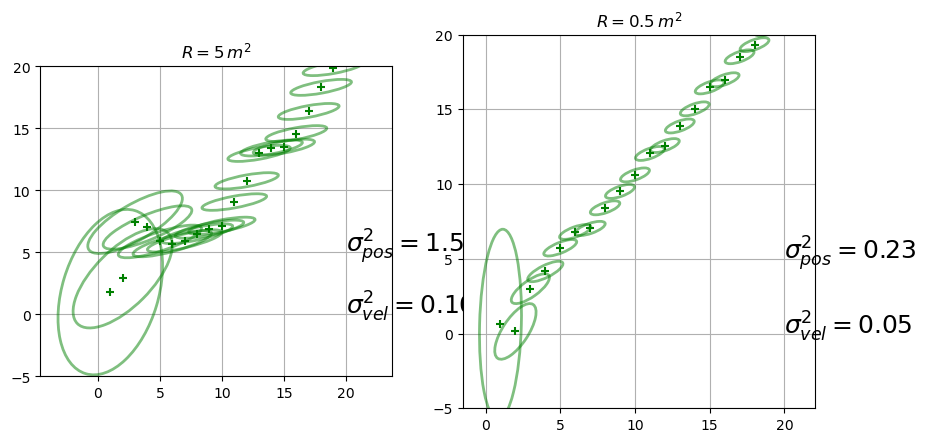

In [155]:
from kf_book.mkf_internal import plot_track_ellipses

def plot_covariances(count, R, Q=0, P=20., title=''):    
    track, zs = compute_dog_data(R, Q, count)
    f = pos_vel_filter(x=(0., 0.), R=R, Q=Q, P=P)

    xs, cov = [], []
    for z in zs:
        f.predict()
        f.update(z)

        xs.append(f.x[0])
        cov.append(f.P)
    plot_track_ellipses(count, zs, xs, cov, title)

plt.figure(figsize=(10,6))
plt.subplot(121)
plot_covariances(R=5, Q=.02, count=20, title='$R = 5\, m^2$')
plt.subplot(122)
plot_covariances(R=.5, Q=.02, count=20, title='$R = 0.5\, m^2$')

If you are viewing this in Jupyter Notebook or on the web, here is an animation of the filter filtering the data. I've tuned the filter parameters such that it is easy to see a change in $\mathbf P$ as the filter progresses.
<img src='animations/multivariate_track1.gif'>

The output on these is a bit messy, but you should be able to see what is happening. In both plots we are drawing the covariance matrix for each point. We start with the covariance $\mathbf P=(\begin{smallmatrix}20&0\\0&20\end{smallmatrix})$, which signifies a lot of uncertainty about our initial belief. After we receive the first measurement the Kalman filter updates this belief, and so the variance is no longer as large. In the top plot the first ellipse (the one on the far left) should be a slightly squashed ellipse. As the filter continues processing the measurements the covariance ellipse quickly shifts shape until it settles down to being a long, narrow ellipse tilted in the direction of movement.

Think about what this means physically. The x-axis of the ellipse denotes our uncertainty in position, and the y-axis our uncertainty in velocity. So, an ellipse that is taller than it is wide signifies that we are more uncertain about the velocity than the position. Conversely, a wide, narrow ellipse shows high uncertainty in position and low uncertainty in velocity. Finally, the amount of tilt shows the amount of correlation between the two variables. 

The first plot, with `R=5` $m^2$, finishes up with an ellipse that is wider than it is tall. If that is not clear I have printed out the variances for the last ellipse in the lower right hand corner.

In contrast, the second plot, with `R=0.5` $m^2$, has a final ellipse that is taller than wide. The ellipses in the second plot are all much smaller than the ellipses in the first plot. This stands to reason because a small $\small\mathbf R$ implies a small amount of noise in our measurements. Small noise means accurate predictions, and thus a strong belief in our position. 

## Question: Explain Ellipse Differences

Why are the ellipses for $\mathbf R=5 m^2$ more tilted towards the horizontal than the ellipses for $\mathbf R=0.5 m^2$. Hint: think about this in the context of what these ellipses mean physically, not in terms of the math. If you aren't sure about the answer,change $\mathbf R$ to truly large and small numbers such as 100 $m^2$ and 0.1 $m^2$, observe the changes, and think about what this means. 

### Solution

The x-axis is for position, and y-axis is velocity. An ellipse that is vertical, or nearly so, says there is no correlation between position and velocity, and an ellipse that is diagonal says that there is a lot of correlation. Phrased that way, the results sound unlikely. The tilt of the ellipse changes, but the correlation shouldn't be changing over time. But this is a measure of the *output of the filter*, not a description of the actual, physical world. When $\mathbf R$ is very large we are telling the filter that there is a lot of noise in the measurements. In that case the Kalman gain $\mathbf K$ is set to favor the prediction over the measurement, and the prediction comes from the velocity state variable. Thus there is a large correlation between $x$ and $\dot x$. Conversely, if $\mathbf R$ is small, we are telling the filter that the measurement is very trustworthy, and $\mathbf K$ is set to favor the measurement over the prediction. Why would the filter want to use the prediction if the measurement is nearly perfect? If the filter is not using much from the prediction there will be very little correlation reported. 

**This is a critical point to understand!**. The Kalman filter is a mathematical model for a real world system. A report of little correlation *does not mean* there is no correlation in the physical system, just that there was no *linear* correlation in the mathematical model. It's a report of how much measurement vs prediction was incorporated into the model.  

Let's bring that point home with a truly large measurement error. We will set $\mathbf R=200\, m^2$. Think about what the plot will look like before looking at it.

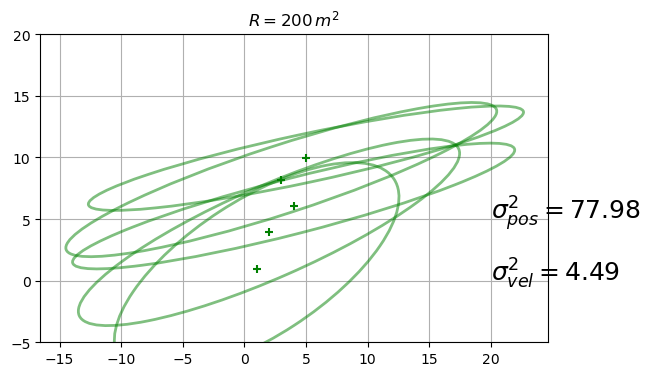

In [156]:
plot_covariances(R=200., Q=.2, count=5, title='$R = 200\, m^2$')

I hope the result was what you were expecting. The ellipse quickly became very wide and not very tall. It did this because the Kalman filter mostly used the prediction vs the measurement to produce the filtered result. We can also see how the filter output is slow to acquire the track. The Kalman filter assumes that the measurements are extremely noisy, and so it is very slow to update its estimate for $\dot x$. 

Keep looking at these plots until you grasp how to interpret the covariance matrix $\mathbf P$. When you work with a $9{\times}9$ matrix it may seem overwhelming - there are 81 numbers to interpret. Just break it down - the diagonal contains the variance for each state variable, and all off diagonal elements are the product of two variances and a scaling factor $p$. You cannot plot a $9{\times}9$ matrix on the screen so you have to develop your intuition and understanding in this simple, 2-D case. 

>When plotting covariance ellipses, make sure to always use ax.set_aspect('equal') or plt.axis('equal') in your code (the former lets you set the xlim and ylim values). If the axis use different scales the ellipses will be drawn distorted. For example, the ellipse may be drawn as being taller than it is wide, but it may actually be wider than tall.

## Filter Initialization


There are many schemes for initializing the filter. The following approach performs well in most situations. In this scheme you do not initialize the filter until you get the first measurement, $\mathbf z_0$. From this you can compute the initial value for $\mathbf x$ with $\mathbf x_0 = \mathbf z_0$. If  $\mathbf z$ is not of the same size, type, and units as $\mathbf x$, which is usually the case, we can use our measurement function as follow.

We know

$$\mathbf z = \mathbf{Hx}$$

Hence,

$$\begin{aligned}
\mathbf H^{-1}\mathbf{Hx} &= \mathbf H^{-1}\mathbf z \\
\mathbf x &= \mathbf H^{-1}\mathbf z\end{aligned}$$

Matrix inversion requires a square matrix, but $\mathbf H$ is rarely square. SciPy will compute the Moore-Penrose pseudo-inverse of a matrix with `scipy.linalg.pinv`, so your code might look like

In [157]:
from scipy.linalg import pinv

H = np.array([[1, 0.]]) 
z0 = 3.2
x = np.dot(pinv(H), z0)
print(x)

[[3.2]
 [0. ]]


Specialized knowledge of your problem domain may lead you to a different computation, but this is one way to do it. For example, if the state includes velocity you might take the first two measurements of position, compute the difference, and use that as the initial velocity.

Now we need to compute a value for $\mathbf P$. This will vary by problem, but in general you will use the measurement error $\mathbf R$ for identical terms, and maximum values for the rest of the terms. Maybe that isn't clear. In this chapter we have been tracking and object using position and velocity as the state, and the measurements have been positions. In that case we would initialize $\mathbf P$ with

$$\mathbf P = \begin{bmatrix}\mathbf R_0 & 0 \\0 & vel_{max}^2\end{bmatrix}$$

The diagonal of $\mathbf P$ contains the variance of each state variable, so we populate it with reasonable values. $\mathbf R_0$ is a reasonable variance for the position, and the maximum velocity squared is a reasonable variance for the velocity. It is squared because variance is squared: $\sigma^2$.

You really need to understand the domain in which you are working and initialize your filter on the best available information. For example, suppose we were trying to track horses in a horse race. The initial measurements might be very bad, and provide you with a position far from the starting gate. We know that the horse must start at the starting gate; initializing the filter to the initial measurement would lead to suboptimal results. In this scenario we would want to always initialize the Kalman filter with the starting gate position of the horse.

## Batch Processing

The Kalman filter is designed as a recursive algorithm - as new measurements come in we immediately create a new estimate. But it is very common to have a set of data that have been already collected which we want to filter. Kalman filters can be run in a batch mode, where all of the measurements are filtered at once. We have implemented this in `KalmanFilter.batch_filter()`. Internally, all the function does is loop over the measurements and collect the resulting state and covariance estimates in arrays. It simplifies your logic and conveniently gathers all of the outputs into arrays. I often use this function, but waited until the end of the chapter so you would become very familiar with the predict/update cyle that you must run.

First collect your measurements into an array or list. Maybe it is in a CSV file:

```python
zs = read_altitude_from_csv('altitude_data.csv')
```

Or maybe you will generate it using a generator:

```python
zs = [some_func(i) for i in range(1000)]
```

Then call the `batch_filter()` method.

```python
Xs, Ps, Xs_prior, Ps_prior = kfilter.batch_filter(zs)
```

The function takes the list of measurements, filters it, and returns an  NumPy array of state estimates (Xs), covariance matrices (Ps), and the priors for the same (Xs_prior, Ps_prior).

Here is a complete example.

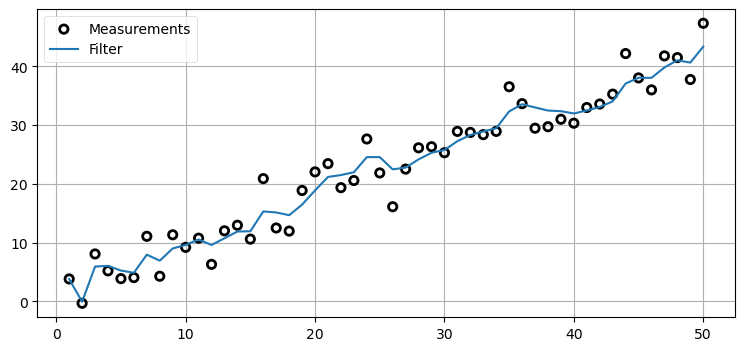

In [158]:
count = 50
track, zs = compute_dog_data(10, .2, count)
P = np.diag([500., 49.])
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
xs, _, _, _ = f.batch_filter(zs)

book_plots.plot_measurements(range(1, count + 1), zs)
book_plots.plot_filter(range(1, count + 1), xs[:, 0])
plt.legend(loc='best');

The batch filter takes an optional `filterpy.common.Saver` object. If provided, all of the filter's attributes will be saved as well. This is useful if you want to inspect values other than the state and covariance. Here I plot the residual to see if it appears like noise centered around 0. This is a quick visual inspection to see if the filter is well designed. If if drifts from zero, or doesn't look like noise, the filter is poorly designed and/or the processes are not Gaussian. We will discuss this in detail in later chapters. For now consider this a demonstration of the `Saver` class.

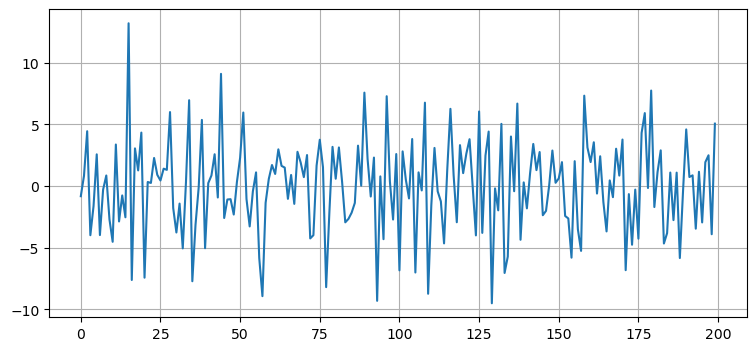

In [159]:
track, zs = compute_dog_data(10, .2, 200)
P = np.diag([500., 49.])
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
s = Saver(f)
xs, _, _, _ = f.batch_filter(zs, saver=s)
s.to_array()
plt.plot(s.y);

## Smoothing the Results

This book includes a chapter on smoothing the results; I will not repeat the information here. However, it is so easy to use, and offers such a profoundly improved output that I will tease you with a few examples. The smoothing chapter is not especially difficult; you are sufficiently prepared to read it now.

Let's assume that we are tracking a car that has been traveling in a straight line. We get a measurement that implies that the car is starting to turn to the left. The Kalman filter moves the state estimate somewhat towards the measurement, but it cannot judge whether this is a particularly noisy measurement or the true start of a turn. 

However, if we have future measurements we can decide if a turn was made. Suppose the subsequent measurements all continue turning left. We can then be sure that that a turn was initiated. On the other hand, if the subsequent measurements continued on in a straight line we would know that the measurement was noisy and should be mostly ignored. Instead of making an estimate part way between the measurement and prediction the estimate will either fully incorporate the measurement or ignore it, depending on what the future measurements imply about the object's movement.

`KalmanFilter` implements a form of this algorithm which is called an *RTS smoother*, named after the inventors of the algorithm: Rauch, Tung, and Striebel. The method is `rts_smoother()`. To use it pass in the means and covariances computed from the `batch_filter` step, and receive back the smoothed means, covariances, and Kalman gain. 

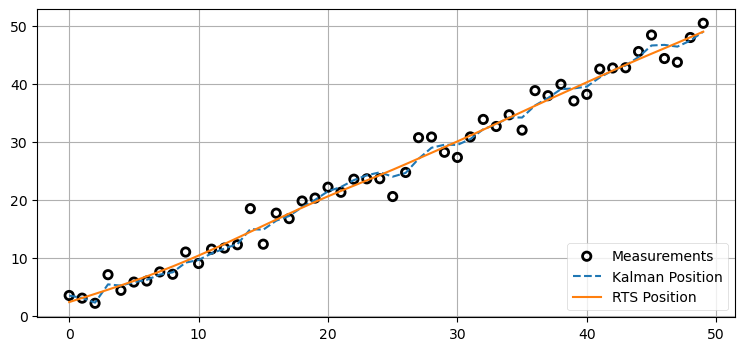

In [160]:
from numpy.random import seed
count = 50
seed(8923)

P = np.diag([500., 49.])
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
track, zs = compute_dog_data(3., .02, count)
Xs, Covs, _, _ = f.batch_filter(zs)
Ms, Ps, _, _ = f.rts_smoother(Xs, Covs)

book_plots.plot_measurements(zs)
plt.plot(Xs[:, 0], ls='--', label='Kalman Position')
plt.plot(Ms[:, 0], label='RTS Position')
plt.legend(loc=4);

This output is fantastic! Two things are very apparent to me in this chart. First, the RTS smoother's output is much smoother than the KF output. Second, it is almost always more accurate than the KF output (we will examine this claim in detail in the **Smoothing** chapter). The improvement in the velocity, which is a hidden variable, is even more dramatic:

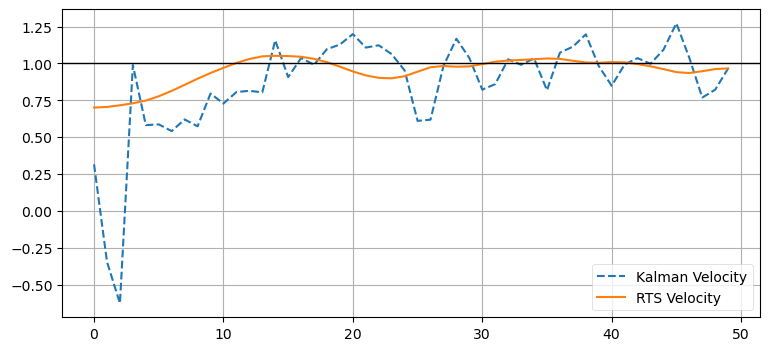

In [161]:
plt.plot(Xs[:, 1], ls='--', label='Kalman Velocity')
plt.plot(Ms[:, 1], label='RTS Velocity')
plt.legend(loc=4)
plt.gca().axhline(1, lw=1, c='k');

We will explore why this is so in the next exercise.

## Exercise: Compare Velocities

Since we are plotting velocities let's look at what the 'raw' velocity is, which we can compute by subtracting subsequent measurements. i.e the velocity at time 1 can be approximated by `xs[1] - xs[0]`. Plot the raw value against the values estimated by the Kalman filter and by the RTS filter. Discuss what you see.

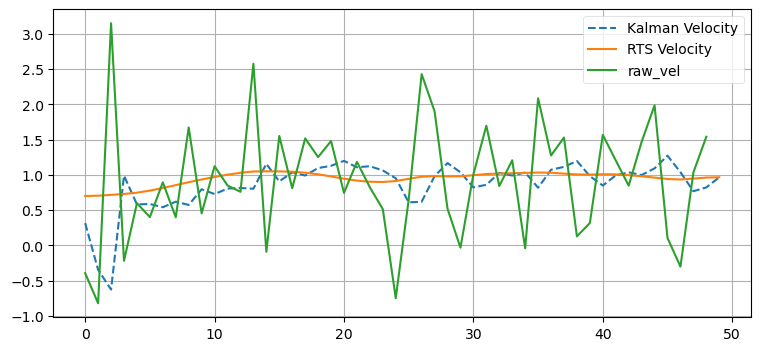

In [174]:
# your code here
raw_vel = np.diff(Xs[:,0])
plt.plot(Xs[:, 1], ls='--', label='Kalman Velocity')
plt.plot(Ms[:, 1], label='RTS Velocity')
plt.plot(raw_vel,label="raw_vel")
plt.legend()

### Solution

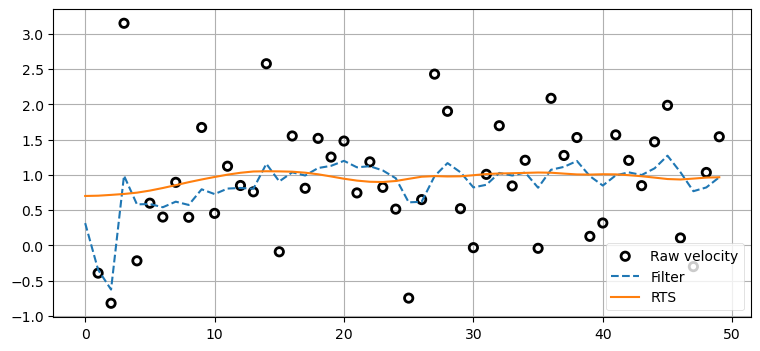

In [163]:
dx = np.diff(Xs[:, 0], axis=0)
plt.scatter(range(1, len(dx) + 1), dx, facecolor='none', 
            edgecolor='k', lw=2, label='Raw velocity')
plt.plot(Xs[:, 1], ls='--', label='Filter')
plt.plot(Ms[:, 1], label='RTS')
plt.legend(loc=4);

We see that the noise swamps the signal, causing the raw values to be essentially worthless. The filter is maintaining a separate estimate for velocity. The Kalman gain $\mathbf K$ is multidimensional. For example, it might have the value  $\mathbf K = [0.1274, 0.843]^\mathsf T$. the first value is used to scale the residual of the position, and the second value will scale the residual of the velocity. The covariance matrix tells the filter how correlated the position and velocity are, and each will be optimally filtered. 

I show this to reiterate the importance of using Kalman filters to compute velocities, accelerations, and even higher order values. I use a Kalman filter even when my measurements are so accurate that I am willing to use them unfiltered because it allows me accurate estimates for velocities and accelerations.

## Discussion and Summary

Multivariate Gaussians allow us to simultaneously handle multiple dimensions, both spacial and others (velocity, etc). We made a key insight: hidden variables have the ability to significantly increase the accuracy of the filter. This is possible because the hidden variables are correlated with the observed variables. 

I gave an intuitive definition of *observability*. Observability was invented by Dr. Kalman for linear systems, and there is a fair amount of theory behind it. It answers the question of whether a system state can be determined by observing the system's output. For our problems this has been easy to determine, but more complicated systems may require rigorous analysis. Wikipedia's [Observability](https://en.wikipedia.org/wiki/Observability) article has an overview; if you need to learn the topic [[2]](#References) is a good source. 

There is one important caveat about hidden variables. It is easy to construct a filter that produces estimates for hidden variables. I could write a filter that estimates the color of a tracked car. But there is no way to compute car color from positions, so the estimate for the color will be nonsense. The designer must verify that these variables are being estimated correctly. If you do not have a velocity sensor and yet are estimating velocity, you will need to test that the velocity estimates are correct.; do not trust that they are. For example, suppose the velocity has a periodic component to it - it looks like a sine wave. If your sample time is less than 2 times the frequency you will not be able to accurately estimate the velocity (due to Nyquist's Theorem). Imagine that the sample period is equal to the frequency of the velocity. The filter will report that the velocity is constant because it samples the system at the same point on the sin wave. 

Initialization poses a particularly difficult problem for hidden variables. If you start with a bad initialization the filter can usually recover the observed variables, but may struggle and fail with the hidden one. Estimating hidden variables is a powerful tool, but a dangerous one. 

I established a series of steps for designing a Kalman filter. These are not a usual part of the Kalman filter literature, and are only meant as a guide, not a prescription. Designing for a hard problem is an iterative process. You make a guess at the state vector, work out what your measurement and state models are, run some tests, and then alter the design as necessary. 

The design of $\mathbf R$ and $\mathbf Q$ is often quite challenging. I've made it appear to be quite scientific. Your sensor has Gaussian noise of $\mathcal{N}(0, \sigma^2)$, so set $\mathbf R=\sigma^2$. Easy! This is a dirty lie. Sensors are not Gaussian. We started the book with a bathroom scale. Suppose $\sigma=1$ kg, and you try to weigh something that weighs 0.5 kg. Theory tells us we will get negative measurements, but of course the scale will never report weights less than zero. Real world sensors typically have *fat tails* (known as *kurtosis*) and *skew*. In some cases, such as with the scale, one or both tails are truncated.

The case with $\mathbf Q$ is more dire. I hope you were skeptical when I blithely assigned a noise matrix to my prediction about the movements of a dog. Who can say what a dog will do next? The Kalman filter in my GPS doesn't know about hills, the outside winds, or my terrible driving skills. Yet the filter requires a precise number to encapsulate all of that information, and it needs to work while I drive off-road in the desert, and when a Formula One champion drives on a track.

These problems led some researchers and engineers to derogatorily call the Kalman filter a 'ball of mud'. In other words, it doesn't always hold together so well. Another term to know - Kalman filters can become *smug*. Their estimates are based solely on what you tell it the noises are. Those values can lead to overly confident estimates. $\mathbf P$ gets smaller and smaller while the filter is actually becoming more and more inaccurate! In the worst case the filter diverges. We will see a lot of that when we start studying nonlinear filters. 

The Kalman filter is a mathematical model of the world. The output is only as accurate as that model. To make the math tractable we had to make some assumptions. We assume that the sensors and motion model have Gaussian noise. We assume that everything is linear. If that is true, the Kalman filter is *optimal* in a least squares sense. This means that there is no way to make a better estimate than what the filter gives us. However, these assumption are almost never true, and hence the model is necessarily limited, and a working filter is rarely optimal.

In later chapters we will deal with the problem of nonlinearity. For now I want you to understand that designing the matrices of a linear filter is an experimental procedure more than a mathematical one. Use math to establish the initial values, but then you need to experiment. If there is a lot of unaccounted noise in the world (wind, etc.) you may have to make $\mathbf Q$ larger. If you make it too large the filter fails to respond quickly to changes. In the **Adaptive Filters** chapter you will learn some alternative techniques that allow you to change the filter design in real time in response to the inputs and performance, but for now you need to find one set of values that works for the conditions your filter will encounter. Noise matrices for an acrobatic plane might be different if the pilot is a student than if the pilot is an expert as the dynamics will be quite different.

## References

- <A name="[wiki_article]">[1]</A> 'Kalman Filters'. Wikipedia
https://en.wikipedia.org/wiki/Kalman_filter#Details

- [2] Grewal, Mohinder S., Andrews, Angus P. *Kalman Filtering: Theory and Practice Using MATLAB*. Third Edition. John Wiley & Sons. 2008.